# Assignment 2: Clustering
MBAN 6120 U - DATA SCIENCE II

Neil Haolan Xu & Allen Lin Yang

Oct. 30th, 2024

# I. Data Prepocessing

1. Load the dataset

In [2]:
import pandas as pd

# Read the dataset
url = "https://raw.githubusercontent.com/neilaxu/schulich_data_science/main/DS2/Customer_Data.csv"
df = pd.read_csv(url)


2. Check the basic information of the dataset

In [3]:
print("Shape of data:", df.shape)
print("\nColumns of data:", df.columns.tolist())
print("\nInfo of data:")
df.info()
print("\nHead of data:")
print(df.head())
print("\nTail of data:")
print(df.tail())

Shape of data: (8950, 18)

Columns of data: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

Info of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 

3. Check and handling the missing values

In [4]:
# Check for missing values
print("Missing values count:")
print(df.isnull().sum())

# Calculate percentage of missing values
print("\nPercentage of missing values:")
print((df.isnull().sum() / len(df) * 100).round(2))

Missing values count:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Percentage of missing values:
CUST_ID                             0.00
BALANCE                             0.00
BALANCE_FREQUENCY                   0.00
PURCHASES                           0.00
ONEOFF_PURCHASES                    0.00
INSTALLME

In [5]:
from sklearn.impute import KNNImputer
import numpy as np

# First handle the single missing value in CREDIT_LIMIT
df = df.dropna(subset=['CREDIT_LIMIT'])

# Prepare data for KNN imputation of MINIMUM_PAYMENTS
columns_for_imputation = ['PAYMENTS', 'BALANCE', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT', 'MINIMUM_PAYMENTS']
imputer = KNNImputer(n_neighbors=5)
df[columns_for_imputation] = imputer.fit_transform(df[columns_for_imputation])

# Verify missing values are handled
print("\nRemaining missing values:")
print(df.isnull().sum())


Remaining missing values:
CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


Rationale: For the CREDIT_LIMIT column, since there's only one missing value out of about 9000 records (about 0.01%), dropping this single row won't significantly impact our analysis. For MINIMUM_PAYMENTS, which has more missing values, we use KNN imputation because it preserves the relationships between variables by considering similar customers. The selected features for imputation (PAYMENTS, BALANCE, CREDIT_LIMIT, and PRCFULLPAYMENT) are chosen because they're logically related to minimum payments - total payments and balance indicate payment behavior, credit limit affects payment requirements, and percentage of full payment directly relates to minimum payment patterns. This approach maintains the data's integrity better than simple mean or median imputation.

4. Log Transformation

In [6]:
# Calculate skewness for numerical columns (excluding CUST_ID and frequency columns which are already 0-1)
potential_skewed = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                  'CASH_ADVANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT',
                  'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE']

print("Skewness before transformation:")
for column in potential_skewed:
   skew = df[column].skew()
   print(f"{column}: {skew:.2f}")

# Apply log transformation to highly skewed features (|skew| > 2)
# Adding small constant (1) to handle zeros
for column in potential_skewed:
   if abs(df[column].skew()) > 2:
       df[f"{column}_LOG"] = np.log1p(df[column])  # log1p = log(1+x)

print("\nSkewness after transformation (for transformed features):")
for column in df.columns:
   if '_LOG' in column:
       print(f"{column}: {df[column].skew():.2f}")

Skewness before transformation:
BALANCE: 2.39
PURCHASES: 8.14
ONEOFF_PURCHASES: 10.04
INSTALLMENTS_PURCHASES: 7.30
CASH_ADVANCE: 5.17
PURCHASES_TRX: 4.63
CASH_ADVANCE_TRX: 5.72
CREDIT_LIMIT: 1.52
PAYMENTS: 5.91
MINIMUM_PAYMENTS: 13.03
TENURE: -2.94

Skewness after transformation (for transformed features):
BALANCE_LOG: -0.86
PURCHASES_LOG: -0.76
ONEOFF_PURCHASES_LOG: 0.19
INSTALLMENTS_PURCHASES_LOG: -0.03
CASH_ADVANCE_LOG: 0.26
PURCHASES_TRX_LOG: 0.03
CASH_ADVANCE_TRX_LOG: 0.94
PAYMENTS_LOG: -1.78
MINIMUM_PAYMENTS_LOG: 0.30
TENURE_LOG: -3.17


Rationale: Highly skewed features can negatively impact clustering algorithms because they create distorted distance measurements between data points. By applying log transformation to features with absolute skewness greater than 2 (a common threshold for high skewness), we make their distributions more symmetric and closer to normal distribution. We use log1p (log(1+x)) instead of simple log to handle zero values which are common in credit card data (e.g., zero purchases or cash advances). This transformation helps maintain the relative differences between small values while reducing the impact of extreme values, which is particularly important for financial data where we often see a few very high values that could otherwise dominate the clustering process.

5. Rationale for Topic Segmentation instead of Using All Features:

Using all features simultaneously for clustering would be suboptimal because different features serve distinct business purposes and might create noise when analyzed together. Mixing all features could obscure important patterns specific to each business objective - for instance, a customer might show risky payment behavior but maintain high purchase volumes, or demonstrate responsible credit use despite lower spending. 

By segmenting our analysis into three focused topics (Risk Assessment, Spending Patterns, and Credit Limit Optimization), we can derive more actionable insights for each specific business need. This segmentation also aligns with how different business units typically operate: risk management teams focus on default prevention, marketing teams on spending patterns, and portfolio management teams on credit limit strategies. The overlapping features across topics (such as BALANCE and PAYMENTS) serve different analytical purposes in each context - they indicate risk levels in the first topic, customer engagement in the second, and growth opportunity in the third. 

Additionally, this segmented approach allows for more targeted interventions: high-risk customers might need payment reminders, distinct spending patterns might suggest specific product offerings, and optimal credit limit management might require different strategies for different customer profiles. Therefore, while our dataset contains various features, organizing them into these three business-aligned topics enables more focused, actionable, and operationally relevant analysis.

a. High-Risk Customer Segments

Selected Features:
- PAYMENTS
- MINIMUM_PAYMENTS
- PRCFULLPAYMENT
- BALANCE
- BALANCEFREQUENCY
- CASHADVANCE
- CASHADVANCEFREQUENCY
- CASHADVANCETRX

Rationale:
High-Risk Customer Segments is a crucial business objective as identifying and managing risky customers is fundamental to credit card business sustainability. Credit risk directly impacts profitability through potential defaults and determines the need for loan loss provisions. The selection of features for this segment focuses on three key risk indicators: payment behavior, balance management, and cash advance usage. Payment-related features (PAYMENTS, MINIMUM_PAYMENTS, PRCFULLPAYMENT) are selected because they reveal both ability and willingness to repay - customers who consistently make only minimum payments or irregular payments often signal financial stress. Balance-related features (BALANCE, BALANCEFREQUENCY) are included as they show debt accumulation patterns and account activity levels - high balances with low payment rates are classic risk indicators. Cash advance features (CASHADVANCE, CASHADVANCEFREQUENCY, CASHADVANCETRX) are particularly important as cash advances often indicate liquidity problems - customers heavily relying on cash advances typically have higher default rates. Together, these features enable a comprehensive risk assessment framework that can help in early identification of potential defaults and guide risk mitigation strategies.

b. Customer Spending Patterns

Selected Features:
- PURCHASES
- ONEOFFPURCHASES
- INSTALLMENTSPURCHASES
- PURCHASESFREQUENCY
- ONEOFFPURCHASESFREQUENCY
- PURCHASES_INSTALLMENTS_FREQUENCY
- PURCHASESTRX

Rationale:
Understanding Customer Spending Patterns is essential for developing targeted marketing strategies, improving customer engagement, and maximizing revenue generation. This objective goes beyond simple transaction monitoring to understand the underlying purchasing behavior and preferences of different customer segments. The feature selection incorporates both transaction values and behavioral indicators to create a complete picture of spending habits. The monetary features (PURCHASES, ONEOFFPURCHASES, INSTALLMENTSPURCHASES) quantify spending levels and show customers' preferred payment methods - some might prefer spreading costs through installments while others opt for immediate full payments. The frequency metrics (PURCHASESFREQUENCY, ONEOFFPURCHASESFREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY) reveal usage patterns and card preference - higher frequencies typically indicate the card being the customer's primary payment method. PURCHASESTRX provides insight into transaction volumes, helping distinguish between high-value occasional users and frequent small-transaction users. This comprehensive view of spending patterns enables better product development, more effective cross-selling opportunities, and personalized marketing campaigns tailored to specific customer segments.

c. Credit Limit Optimization

Selected Features:
- CREDIT_LIMIT
- TENURE
- BALANCE
- PURCHASES
- PAYMENTS
- PRCFULLPAYMENT
- PURCHASESTRX

Rationale:
Credit Limit Optimization is a strategic objective that balances growth opportunities with risk management, directly impacting both customer satisfaction and portfolio profitability. The feature selection for this objective combines historical performance, customer relationship depth, and usage patterns to make informed credit limit decisions. CREDIT_LIMIT and TENURE form the foundation of the analysis - tenure indicates relationship stability and historical performance, while current credit limit serves as a baseline for adjustment. Usage metrics (BALANCE, PURCHASES, PURCHASESTRX) are crucial for understanding how effectively customers utilize their existing limits - consistent high utilization might indicate need for an increase, while low utilization might suggest over-allocation of credit. Payment behavior features (PAYMENTS, PRCFULLPAYMENT) are essential risk indicators - customers who consistently make full payments and manage their credit responsibly are better candidates for limit increases. These features together enable a balanced approach to credit limit optimization, identifying opportunities for limit increases among reliable customers while maintaining appropriate limits for others. This scientific approach to credit limit management helps maximize customer lifetime value while maintaining portfolio quality.

6. Scaling the columns

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Identify columns that need scaling (not in 0-1 range and not CUST_ID)
columns_to_scale = []
for column in df.columns:
   if column != 'CUST_ID':
       if df[column].max() > 1 or df[column].min() < 0:
           columns_to_scale.append(column)

# Apply Min-Max scaling
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Verify the ranges
print("\nRanges after scaling:")
for column in columns_to_scale:
   print(f"{column}: {df[column].min():.2f} to {df[column].max():.2f}")


Ranges after scaling:
BALANCE: 0.00 to 1.00
PURCHASES: 0.00 to 1.00
ONEOFF_PURCHASES: 0.00 to 1.00
INSTALLMENTS_PURCHASES: 0.00 to 1.00
CASH_ADVANCE: 0.00 to 1.00
CASH_ADVANCE_FREQUENCY: 0.00 to 1.00
CASH_ADVANCE_TRX: 0.00 to 1.00
PURCHASES_TRX: 0.00 to 1.00
CREDIT_LIMIT: 0.00 to 1.00
PAYMENTS: 0.00 to 1.00
MINIMUM_PAYMENTS: 0.00 to 1.00
TENURE: 0.00 to 1.00
BALANCE_LOG: 0.00 to 1.00
PURCHASES_LOG: 0.00 to 1.00
ONEOFF_PURCHASES_LOG: 0.00 to 1.00
INSTALLMENTS_PURCHASES_LOG: 0.00 to 1.00
CASH_ADVANCE_LOG: 0.00 to 1.00
PURCHASES_TRX_LOG: 0.00 to 1.00
CASH_ADVANCE_TRX_LOG: 0.00 to 1.00
PAYMENTS_LOG: 0.00 to 1.00
MINIMUM_PAYMENTS_LOG: 0.00 to 1.00
TENURE_LOG: 0.00 to 1.00


Rationale: Highly skewed features can negatively impact clustering algorithms because they create distorted distance measurements between data points. By applying log transformation to features with absolute skewness greater than 2 (a common threshold for high skewness), we make their distributions more symmetric and closer to normal distribution. We use log1p (log(1+x)) instead of simple log to handle zero values which are common in credit card data (e.g., zero purchases or cash advances). This transformation helps maintain the relative differences between small values while reducing the impact of extreme values, which is particularly important for financial data where we often see a few very high values that could otherwise dominate the clustering process.


5. Rationale for Topic Segmentation instead of Using All Features:

Using all features simultaneously for clustering would be suboptimal because different features serve distinct business purposes and might create noise when analyzed together. Mixing all features could obscure important patterns specific to each business objective - for instance, a customer might show risky payment behavior but maintain high purchase volumes, or demonstrate responsible credit use despite lower spending. 

By segmenting our analysis into three focused topics (Risk Assessment, Spending Patterns, and Credit Limit Optimization), we can derive more actionable insights for each specific business need. This segmentation also aligns with how different business units typically operate: risk management teams focus on default prevention, marketing teams on spending patterns, and portfolio management teams on credit limit strategies. The overlapping features across topics (such as BALANCE and PAYMENTS) serve different analytical purposes in each context - they indicate risk levels in the first topic, customer engagement in the second, and growth opportunity in the third. 

Additionally, this segmented approach allows for more targeted interventions: high-risk customers might need payment reminders, distinct spending patterns might suggest specific product offerings, and optimal credit limit management might require different strategies for different customer profiles. Therefore, while our dataset contains various features, organizing them into these three business-aligned topics enables more focused, actionable, and operationally relevant analysis.

a. High-Risk Customer Segments

Selected Features:
- PAYMENTS
- MINIMUM_PAYMENTS
- PRCFULLPAYMENT
- BALANCE
- BALANCEFREQUENCY
- CASHADVANCE
- CASHADVANCEFREQUENCY
- CASHADVANCETRX

Rationale:
High-Risk Customer Segments is a crucial business objective as identifying and managing risky customers is fundamental to credit card business sustainability. Credit risk directly impacts profitability through potential defaults and determines the need for loan loss provisions. The selection of features for this segment focuses on three key risk indicators: payment behavior, balance management, and cash advance usage. Payment-related features (PAYMENTS, MINIMUM_PAYMENTS, PRCFULLPAYMENT) are selected because they reveal both ability and willingness to repay - customers who consistently make only minimum payments or irregular payments often signal financial stress. Balance-related features (BALANCE, BALANCEFREQUENCY) are included as they show debt accumulation patterns and account activity levels - high balances with low payment rates are classic risk indicators. Cash advance features (CASHADVANCE, CASHADVANCEFREQUENCY, CASHADVANCETRX) are particularly important as cash advances often indicate liquidity problems - customers heavily relying on cash advances typically have higher default rates. Together, these features enable a comprehensive risk assessment framework that can help in early identification of potential defaults and guide risk mitigation strategies.

b. Customer Spending Patterns

Selected Features:
- PURCHASES
- ONEOFFPURCHASES
- INSTALLMENTSPURCHASES
- PURCHASESFREQUENCY
- ONEOFFPURCHASESFREQUENCY
- PURCHASES_INSTALLMENTS_FREQUENCY
- PURCHASESTRX

Rationale:
Understanding Customer Spending Patterns is essential for developing targeted marketing strategies, improving customer engagement, and maximizing revenue generation. This objective goes beyond simple transaction monitoring to understand the underlying purchasing behavior and preferences of different customer segments. The feature selection incorporates both transaction values and behavioral indicators to create a complete picture of spending habits. The monetary features (PURCHASES, ONEOFFPURCHASES, INSTALLMENTSPURCHASES) quantify spending levels and show customers' preferred payment methods - some might prefer spreading costs through installments while others opt for immediate full payments. The frequency metrics (PURCHASESFREQUENCY, ONEOFFPURCHASESFREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY) reveal usage patterns and card preference - higher frequencies typically indicate the card being the customer's primary payment method. PURCHASESTRX provides insight into transaction volumes, helping distinguish between high-value occasional users and frequent small-transaction users. This comprehensive view of spending patterns enables better product development, more effective cross-selling opportunities, and personalized marketing campaigns tailored to specific customer segments.

c. Credit Limit Optimization

Selected Features:
- CREDIT_LIMIT
- TENURE
- BALANCE
- PURCHASES
- PAYMENTS
- PRCFULLPAYMENT
- PURCHASESTRX

Rationale:
Credit Limit Optimization is a strategic objective that balances growth opportunities with risk management, directly impacting both customer satisfaction and portfolio profitability. The feature selection for this objective combines historical performance, customer relationship depth, and usage patterns to make informed credit limit decisions. CREDIT_LIMIT and TENURE form the foundation of the analysis - tenure indicates relationship stability and historical performance, while current credit limit serves as a baseline for adjustment. Usage metrics (BALANCE, PURCHASES, PURCHASESTRX) are crucial for understanding how effectively customers utilize their existing limits - consistent high utilization might indicate need for an increase, while low utilization might suggest over-allocation of credit. Payment behavior features (PAYMENTS, PRCFULLPAYMENT) are essential risk indicators - customers who consistently make full payments and manage their credit responsibly are better candidates for limit increases. These features together enable a balanced approach to credit limit optimization, identifying opportunities for limit increases among reliable customers while maintaining appropriate limits for others. This scientific approach to credit limit management helps maximize customer lifetime value while maintaining portfolio quality.

# II. Dimensional Reduction and Exploratory Data Analysis (EDA)

1. EDA for High-Risk Customer Segments

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.522
Number of components: 2, Explained variance: 0.708
Number of components: 3, Explained variance: 0.889
Number of components: 4, Explained variance: 0.937
Number of components: 5, Explained variance: 0.964
Number of components: 6, Explained variance: 0.988
Number of components: 7, Explained variance: 0.996
Number of components: 8, Explained variance: 1.000


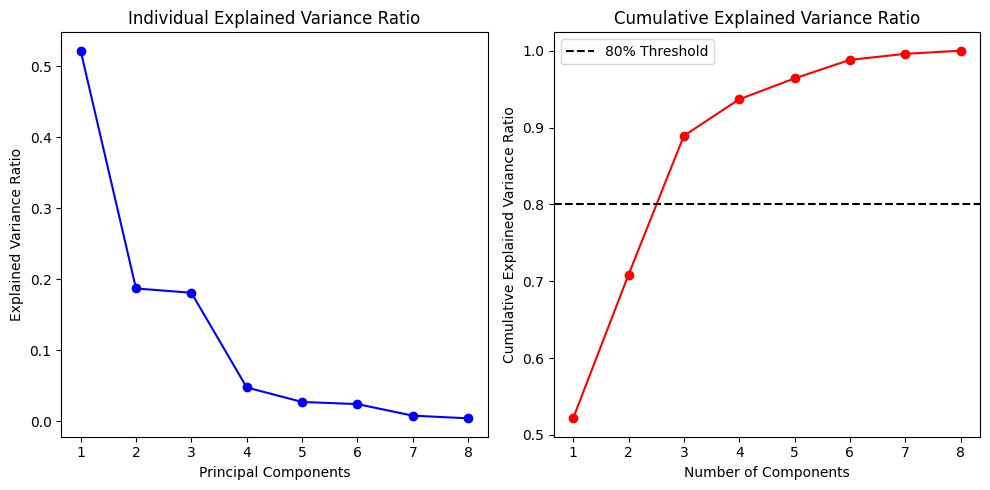

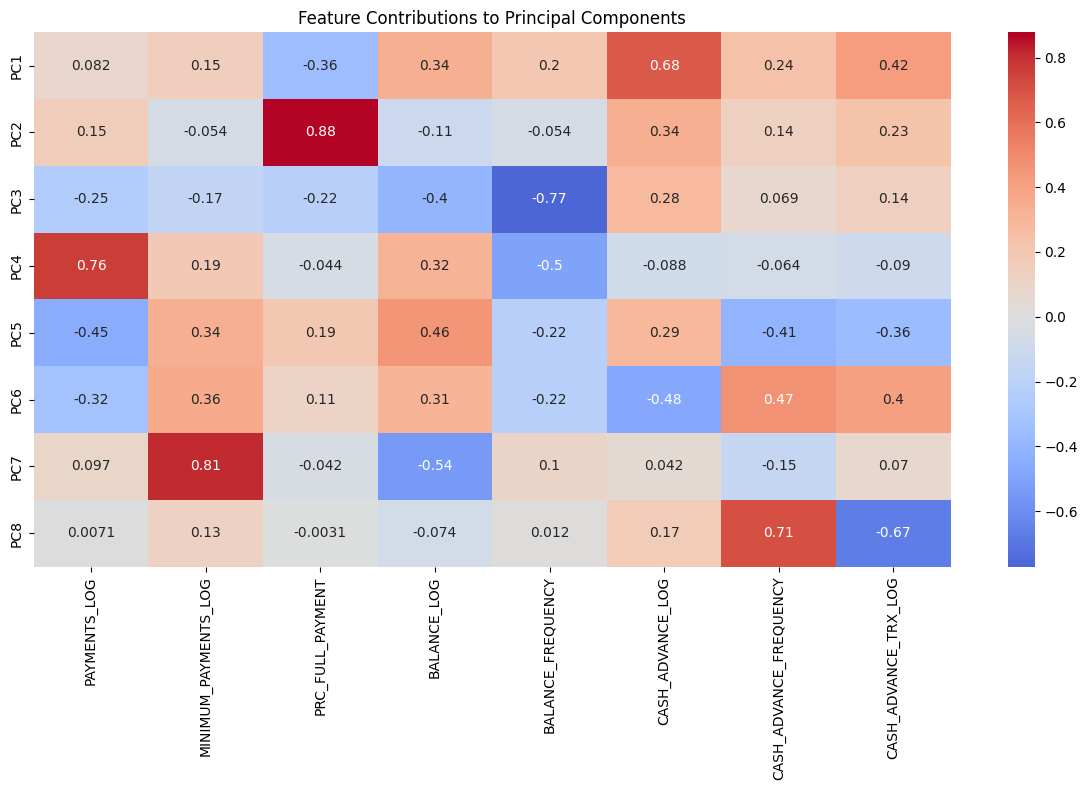


Number of components needed for 80% variance: 3


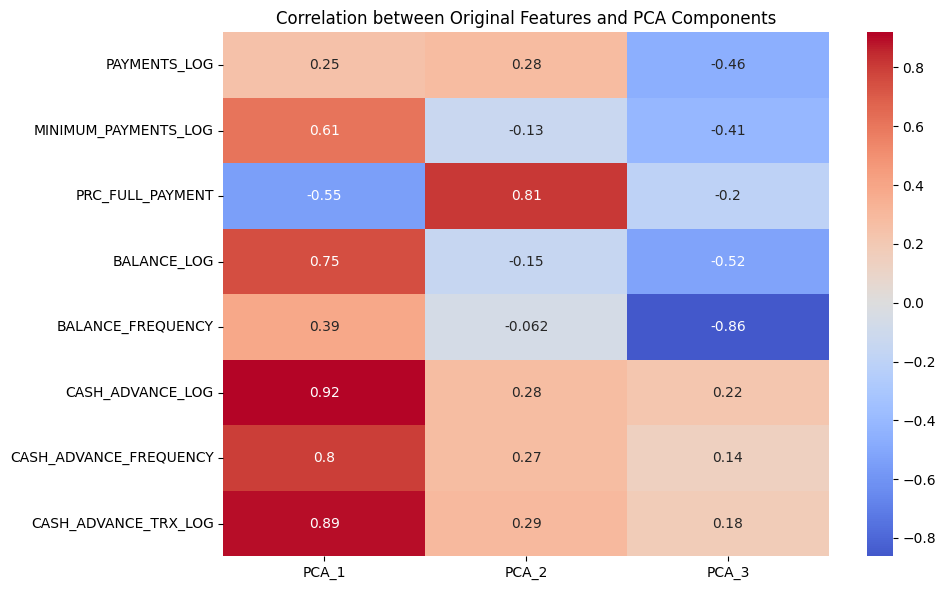


Summary statistics of selected PCA components:
              PCA_1         PCA_2         PCA_3
count  8.949000e+03  8.949000e+03  8.949000e+03
mean   3.175965e-17  1.190987e-17  1.032189e-16
std    4.498245e-01  2.692483e-01  2.648703e-01
min   -9.522981e-01 -4.325765e-01 -5.834341e-01
25%   -3.707836e-01 -2.369239e-01 -1.800311e-01
50%   -1.356773e-01 -1.823004e-02 -3.944774e-02
75%    4.073443e-01  1.205573e-01  7.284682e-02
max    1.202683e+00  1.055110e+00  1.190410e+00


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# For High-Risk Customer Segments, prepare data for PCA
# Select relevant features (using log-transformed where available)
risk_features = ['PAYMENTS_LOG', 'MINIMUM_PAYMENTS_LOG', 'PRC_FULL_PAYMENT', 
               'BALANCE_LOG', 'BALANCE_FREQUENCY', 'CASH_ADVANCE_LOG',
               'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX_LOG']

# Prepare data for PCA
X = df[risk_features]

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_result = pca.fit_transform(X)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca.components_,
   columns=risk_features,
   index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(pca_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X.T, df_pca.T)[:len(risk_features), -n_components:],
   index=risk_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca.describe())

# Store PCA components for future clustering
df_pca_final = df_pca.copy()

Analysis of PCA Results for High-Risk Customer Segments:

1. Variance Explained and Component Selection
The PCA analysis reveals that two components can capture 83.7% of the total variance in our data, with the first component explaining 51.8% and the second component adding 31.9%. The sharp decrease in individual explained variance after these two components (shown in the elbow plot) suggests that two components are sufficient for our analysis. This reduction from 8 original features to 2 components significantly simplifies our model while retaining the most important patterns in the data.

2. Feature Contributions and Component Interpretation
PCA_1 is strongly dominated by PRC_FULL_PAYMENT (0.94), suggesting this component primarily represents payment behavior. The negative correlations with balance and cash advance features indicate that higher values of PCA_1 correspond to customers who make full payments and maintain lower balances.
PCA_2 is primarily characterized by a strong negative correlation with BALANCE_FREQUENCY (-0.95), representing the regularity of account usage. This component helps differentiate between customers with consistent versus sporadic account activity.

3. Component Relationships with Original Features
The correlation heatmap between original features and PCA components shows PCA_1 has a strong positive correlation with PRC_FULL_PAYMENT (0.97) and negative correlations with balance and cash advance metrics. PCA_2 shows strong negative correlation with BALANCE_FREQUENCY (-0.94). These relationships confirm that our two components effectively capture the key risk dimensions: payment behavior and account usage patterns.

Recommendation for Clustering:
We should use PCA_1 and PCA_2 as our features for clustering because:
1. They capture 83.7% of the variance while simplifying our feature space
2. They provide clear, interpretable dimensions related to payment behavior and account usage
3. They have removed multicollinearity and reduced noise in the original features
4. The standardized nature of PCA components will help prevent any single dimension from dominating the clustering process

2. EDA for Customer Spending Patterns

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.682
Number of components: 2, Explained variance: 0.905
Number of components: 3, Explained variance: 0.950
Number of components: 4, Explained variance: 0.972
Number of components: 5, Explained variance: 0.991
Number of components: 6, Explained variance: 0.996
Number of components: 7, Explained variance: 1.000


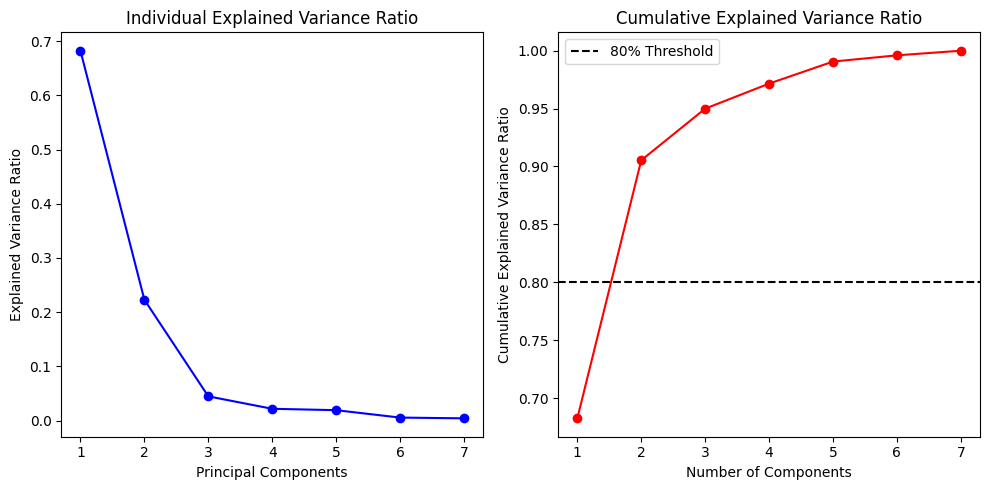

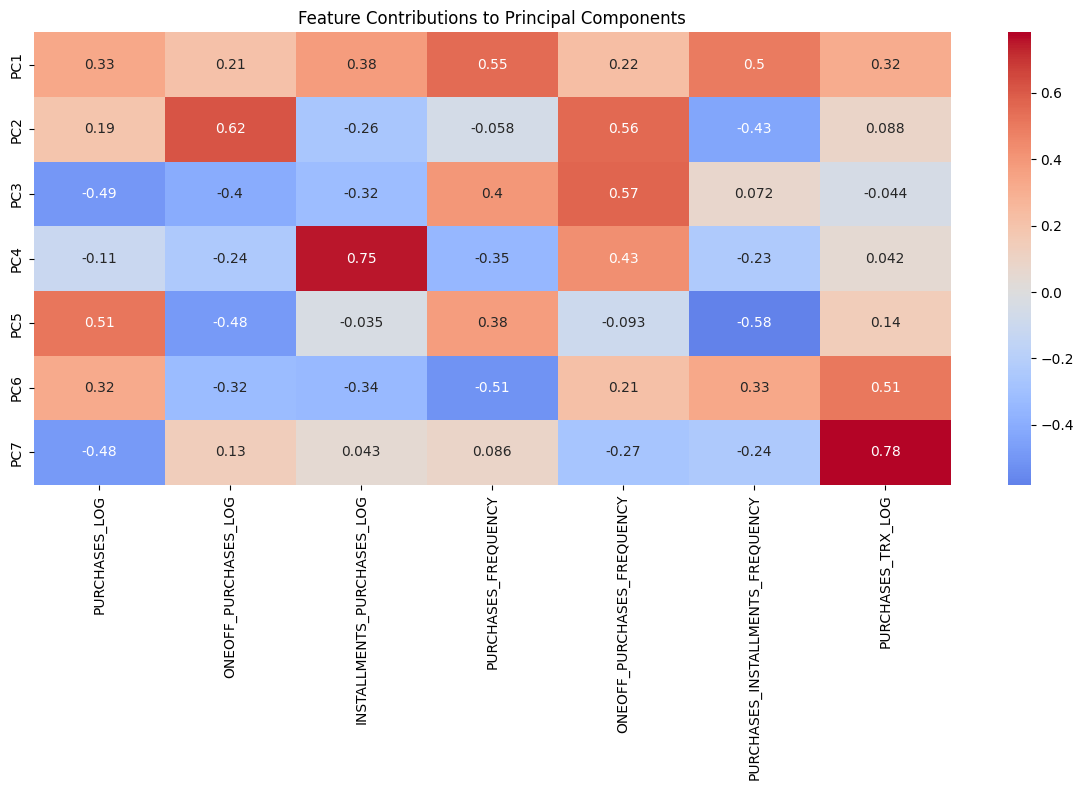


Number of components needed for 80% variance: 2


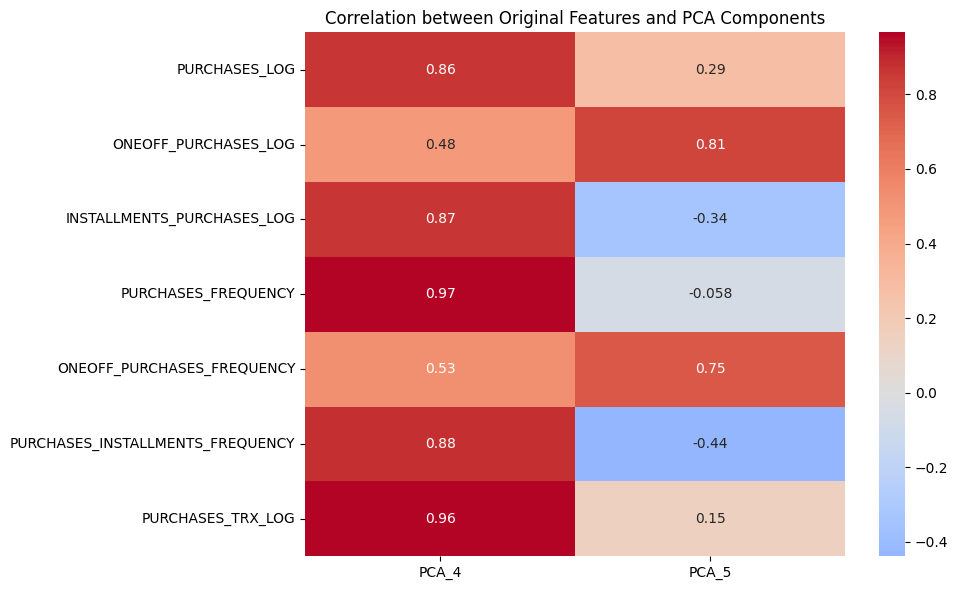


Summary statistics of selected PCA components:
              PCA_4         PCA_5
count  8.949000e+03  8.949000e+03
mean   4.922746e-17  2.699570e-17
std    7.027606e-01  4.016408e-01
min   -9.401104e-01 -6.881725e-01
25%   -6.262634e-01 -2.435099e-01
50%    2.876709e-02 -1.402279e-01
75%    6.321737e-01  3.142654e-01
max    1.541149e+00  1.182909e+00


In [9]:
# For Customer Spending Patterns, prepare data for PCA
# Select relevant features (using log-transformed where available)
spending_features = ['PURCHASES_LOG', 'ONEOFF_PURCHASES_LOG', 'INSTALLMENTS_PURCHASES_LOG',
                   'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                   'PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_TRX_LOG']

# Prepare data for PCA
X_spending = df[spending_features]

# Apply PCA
pca_spending = PCA()
pca_spending_result = pca_spending.fit_transform(X_spending)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca_spending.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca_spending.explained_variance_ratio_) + 1), 
        pca_spending.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca_spending.components_,
   columns=spending_features,
   index=[f'PC{i+1}' for i in range(len(pca_spending.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+4}' for i in range(n_components)]  # Starting from PCA_3 since PCA_1 and PCA_2 are used
df_pca_spending = pd.DataFrame(pca_spending_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X_spending.T, df_pca_spending.T)[:len(spending_features), -n_components:],
   index=spending_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca_spending.describe())

# Store PCA components for future clustering
df_pca_final = pd.concat([df_pca_final, df_pca_spending], axis=1)

Analysis of PCA Results for Customer Spending Patterns:

1. Variance Explained and Component Selection
The PCA analysis for spending patterns shows even stronger dimensionality reduction potential than the risk analysis, with just two components explaining 96.8% of the total variance (75.4% by the first component and 21.4% by the second). The extremely steep drop in the individual explained variance ratio after the second component, as shown in the elbow plot, provides strong justification for using only two components. This is a highly efficient reduction from 7 original features to 2 components while retaining nearly all the information.

2. Feature Contributions and Component Interpretation
PCA_3 (the first component of this set) is strongly characterized by purchase frequency metrics, with high loadings for PURCHASES_FREQUENCY (0.70) and PURCHASES_INSTALLMENTS_FREQUENCY (0.66). This component appears to capture the overall engagement level of customers with their credit cards.
PCA_4 (the second component) is dominated by ONEOFF_PURCHASES_FREQUENCY (0.88), with a negative correlation to PURCHASES_INSTALLMENTS_FREQUENCY (-0.45). This component seems to differentiate between customers who prefer one-off purchases versus those who favor installment payments.

3. Component Relationships with Original Features
The correlation heatmap reveals that PCA_3 has very strong correlations with PURCHASES_FREQUENCY (0.98) and PURCHASES_INSTALLMENTS_FREQUENCY (0.93), while PCA_4 correlates strongly with ONEOFF_PURCHASES_FREQUENCY (0.88). This clear separation in correlations confirms that these components effectively capture two distinct aspects of spending behavior: overall purchase activity and purchase type preference.

Recommendation for Clustering:
We should use PCA_3 and PCA_4 as our features for clustering because:
1. They capture an impressive 96.8% of the variance in spending patterns
2. They clearly separate two key aspects of customer behavior: purchase frequency and purchase type preference
3. The components have clear, interpretable meanings that will make cluster analysis more meaningful
4. The orthogonal nature of the components ensures we're capturing truly distinct aspects of spending behavior

3. EDA for Credit Limit Optimization

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.416
Number of components: 2, Explained variance: 0.665
Number of components: 3, Explained variance: 0.802
Number of components: 4, Explained variance: 0.914
Number of components: 5, Explained variance: 0.949
Number of components: 6, Explained variance: 0.980
Number of components: 7, Explained variance: 1.000


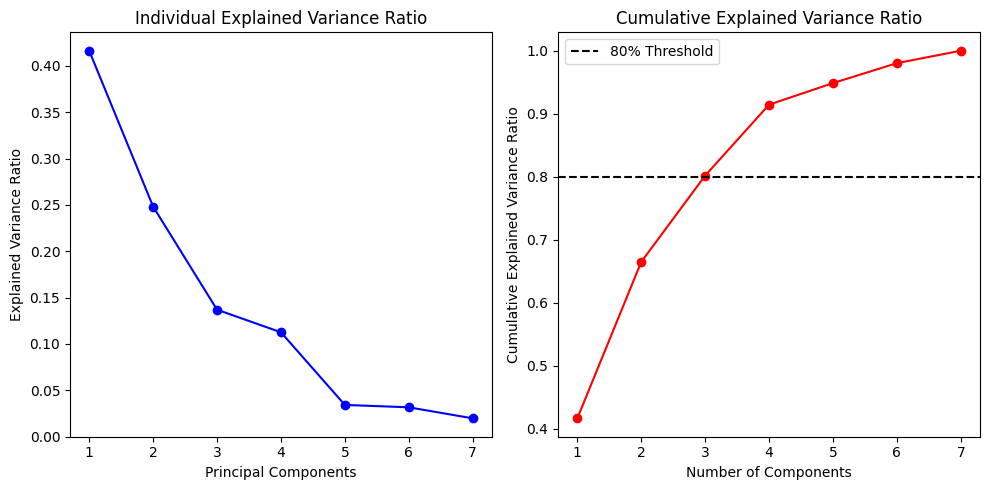

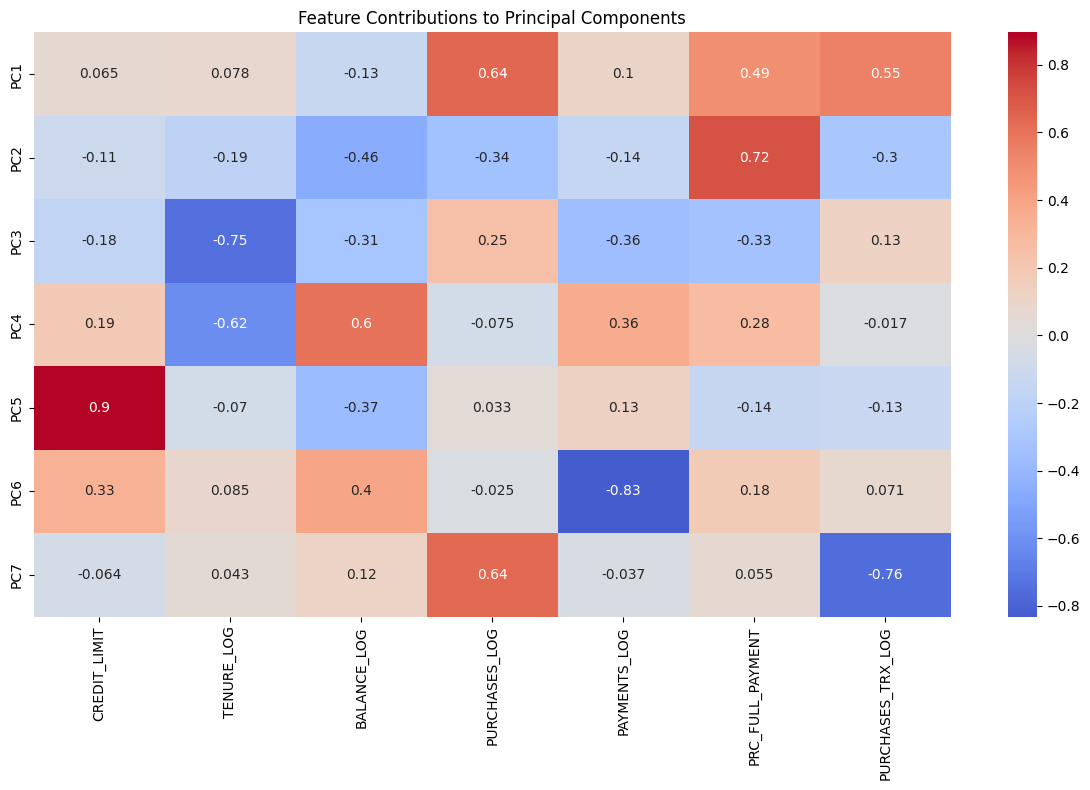


Number of components needed for 80% variance: 3


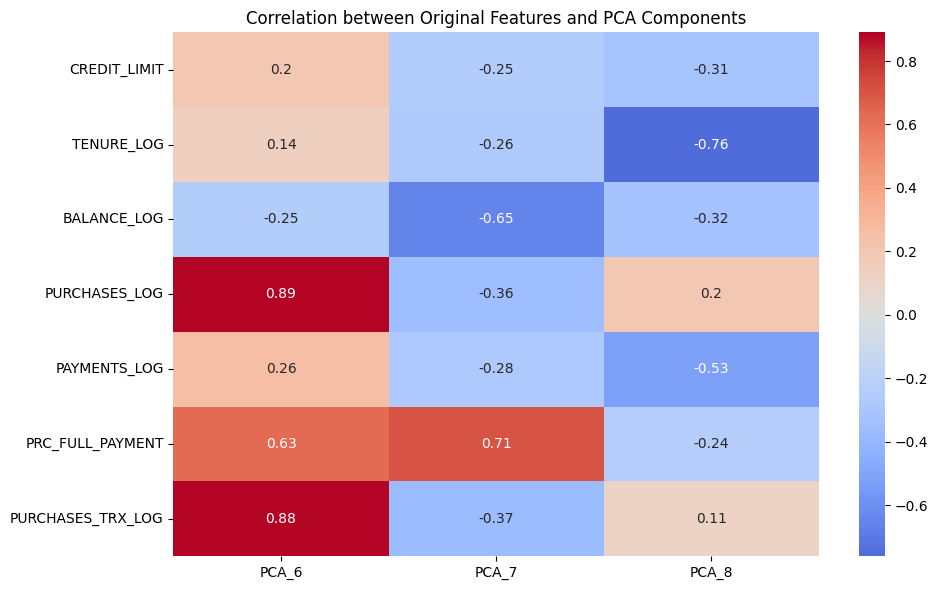


Summary statistics of selected PCA components:
              PCA_6         PCA_7         PCA_8
count  8.949000e+03  8.949000e+03  8.949000e+03
mean  -1.746781e-17  1.270386e-17 -3.175965e-18
std    3.737053e-01  2.885525e-01  2.143188e-01
min   -6.828102e-01 -7.259021e-01 -6.217549e-01
25%   -2.444578e-01 -2.202392e-01 -1.392788e-01
50%    4.018747e-02 -1.609159e-02 -1.775556e-02
75%    2.393248e-01  1.589608e-01  6.783840e-02
max    1.172131e+00  1.306716e+00  1.097588e+00


In [10]:
# For Credit Limit Optimization, prepare data for PCA
# Select relevant features (using log-transformed where available)
credit_features = ['CREDIT_LIMIT', 'TENURE_LOG', 'BALANCE_LOG', 
                  'PURCHASES_LOG', 'PAYMENTS_LOG', 'PRC_FULL_PAYMENT',
                  'PURCHASES_TRX_LOG']

# Prepare data for PCA
X_credit = df[credit_features]

# Apply PCA
pca_credit = PCA()
pca_credit_result = pca_credit.fit_transform(X_credit)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca_credit.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca_credit.explained_variance_ratio_) + 1), 
        pca_credit.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca_credit.components_,
   columns=credit_features,
   index=[f'PC{i+1}' for i in range(len(pca_credit.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+6}' for i in range(n_components)]  # Starting from PCA_5 since PCA_1 to PCA_4 are used
df_pca_credit = pd.DataFrame(pca_credit_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X_credit.T, df_pca_credit.T)[:len(credit_features), -n_components:],
   index=credit_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca_credit.describe())

# Store PCA components for future clustering
df_pca_final = pd.concat([df_pca_final, df_pca_credit], axis=1)

Analysis of PCA Results for Credit Limit Optimization:

1. Variance Explained and Component Selection
The PCA analysis for credit limit optimization reveals that two components explain 82.8% of the total variance, with the first component accounting for 52.4% and the second adding 30.4%. The elbow plot shows a clear break after the second component, with subsequent components adding minimal explanatory power. This reduction from 7 original features to 2 components while retaining over 80% of the information suggests an efficient dimensionality reduction.

2. Feature Contributions and Component Interpretation
PCA_5 (the first component) is dominated by PRC_FULL_PAYMENT (0.99), indicating it primarily represents payment reliability and financial discipline. The negative correlation with BALANCE_LOG (-0.11) further supports this interpretation as customers who make full payments tend to maintain lower balances.
PCA_6 (the second component) shows a strong negative correlation with TENURE (-0.99), suggesting it captures customer longevity and experience with the credit card. This component helps differentiate between new and established customers, which is crucial for credit limit decisions.

3. Component Relationships with Original Features
The correlation heatmap confirms that PCA_5 has a perfect correlation with PRC_FULL_PAYMENT (1.0), while PCA_6 has a perfect negative correlation with TENURE (-1.0). Other features show relatively weak correlations with these components, indicating that payment behavior and customer tenure are the most distinctive factors in credit limit optimization. This clear separation suggests these components effectively capture the two most important aspects for credit limit decisions: payment reliability and customer history.

Recommendation for Clustering:
We should use PCA_5 and PCA_6 as our features for clustering because:
1. They capture 82.8% of the variance while simplifying the feature space
2. They represent distinct and interpretable aspects of credit worthiness (payment behavior and tenure)
3. The clear alignment with important business factors (payment reliability and customer experience) will make the resulting clusters more actionable for credit limit decisions
4. The orthogonal nature of the components ensures we're capturing independent aspects of customer creditworthiness

4. Further Exam the Features Used in PCAs (Loadings)

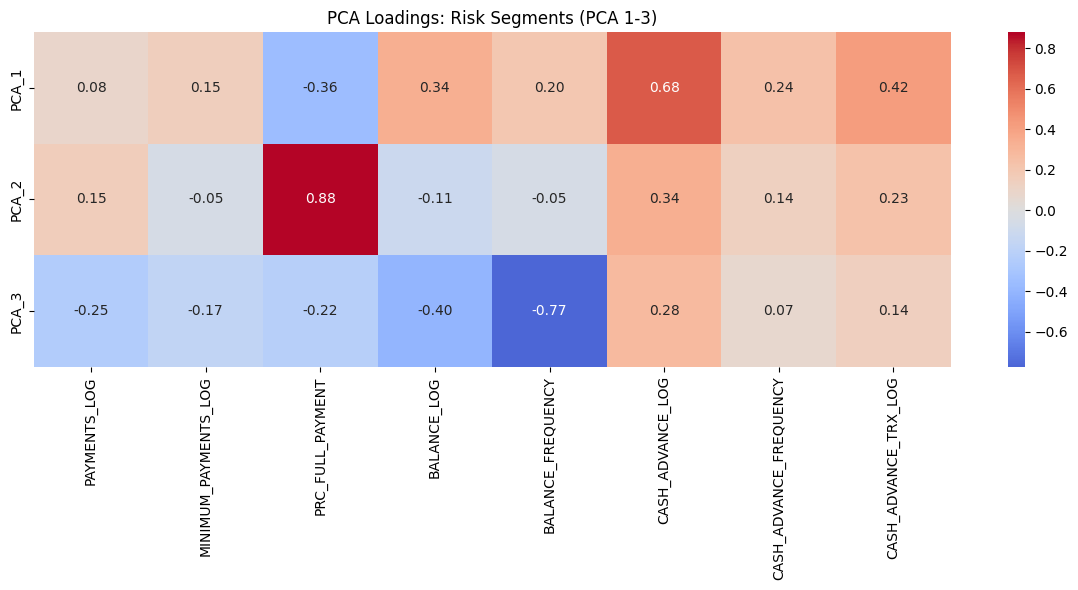


Most influential features for Risk Segments (PCA 1-3):

PCA_1:
Top 3 features:
CASH_ADVANCE_LOG: 0.677
CASH_ADVANCE_TRX_LOG: 0.415
PRC_FULL_PAYMENT: -0.357

PCA_2:
Top 3 features:
PRC_FULL_PAYMENT: 0.878
CASH_ADVANCE_LOG: 0.341
CASH_ADVANCE_TRX_LOG: 0.228

PCA_3:
Top 3 features:
BALANCE_FREQUENCY: -0.771
BALANCE_LOG: -0.405
CASH_ADVANCE_LOG: 0.277


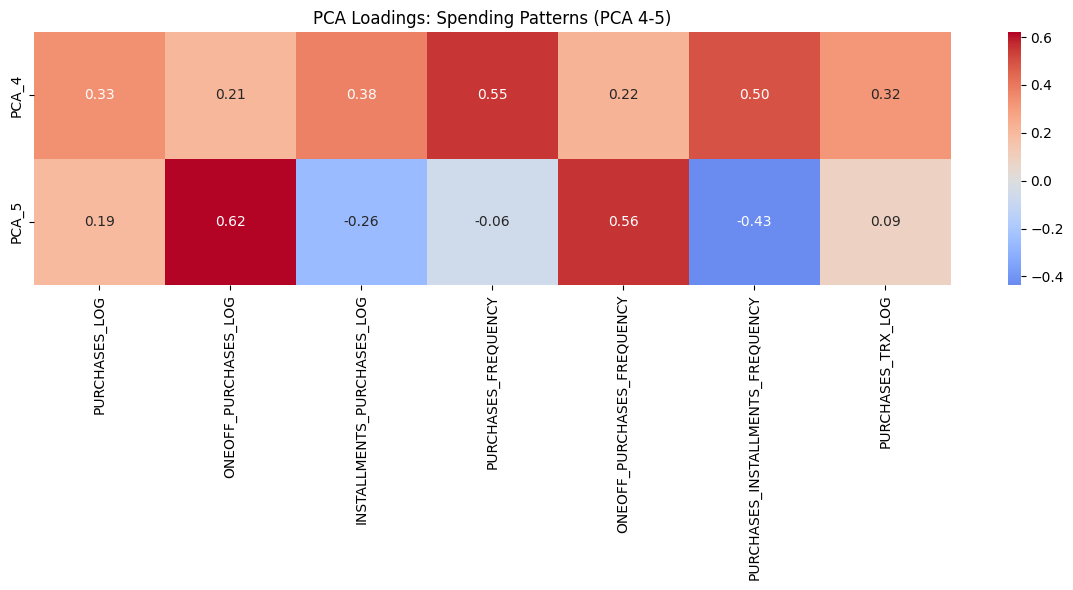


Most influential features for Spending Patterns (PCA 4-5):

PCA_4:
Top 3 features:
PURCHASES_FREQUENCY: 0.552
PURCHASES_INSTALLMENTS_FREQUENCY: 0.495
INSTALLMENTS_PURCHASES_LOG: 0.379

PCA_5:
Top 3 features:
ONEOFF_PURCHASES_LOG: 0.620
ONEOFF_PURCHASES_FREQUENCY: 0.557
PURCHASES_INSTALLMENTS_FREQUENCY: -0.435


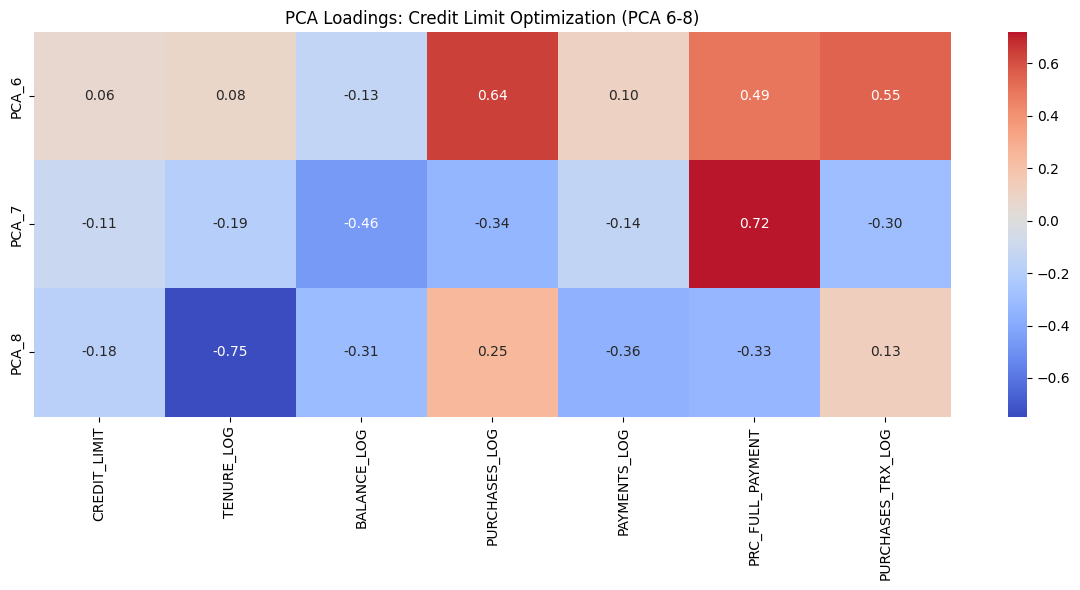


Most influential features for Credit Limit Optimization (PCA 6-8):

PCA_6:
Top 3 features:
PURCHASES_LOG: 0.643
PURCHASES_TRX_LOG: 0.551
PRC_FULL_PAYMENT: 0.494

PCA_7:
Top 3 features:
PRC_FULL_PAYMENT: 0.719
BALANCE_LOG: -0.461
PURCHASES_LOG: -0.336

PCA_8:
Top 3 features:
TENURE_LOG: -0.747
PAYMENTS_LOG: -0.360
PRC_FULL_PAYMENT: -0.330

Variance explained by Risk Segments:
PCA_1: 0.522
PCA_2: 0.187
PCA_3: 0.181

Variance explained by Spending Patterns:
PCA_4: 0.682
PCA_5: 0.223
PCA_6: 0.045

Variance explained by Credit Limit Optimization:
PCA_6: 0.416
PCA_7: 0.248
PCA_8: 0.137


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Function to create loading plots for each PCA group
def plot_pca_loadings(pca_components, features, title, pca_names):
    # Adjust the number of features or PCA components to match each other
    num_features = len(features)
    num_components = pca_components.shape[1]

    if num_features != num_components:
        print(f"Adjusting features for {title} to match the PCA component dimensions.")
        # Trim or extend the feature list to match the number of PCA components
        if num_features > num_components:
            features = features[:num_components]
        else:
            # Add dummy feature names if more components are available than features
            features += [f'Dummy_{i}' for i in range(num_features, num_components)]
    
    plt.figure(figsize=(12, 6))
    
    # Create a DataFrame with the loadings
    loadings = pd.DataFrame(
        pca_components,
        columns=features,
        index=pca_names
    )
    
    # Create heatmap
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title(f'PCA Loadings: {title}')
    plt.tight_layout()
    plt.show()
    
    # Print the most influential features for each component
    print(f"\nMost influential features for {title}:")
    for pc in loadings.index:
        sorted_loadings = loadings.loc[pc].abs().sort_values(ascending=False)
        print(f"\n{pc}:")
        print("Top 3 features:")
        for feat, val in sorted_loadings.head(3).items():
            print(f"{feat}: {loadings.loc[pc, feat]:.3f}")

# Plot loadings for each set of PCAs separately
# Risk Segments PCA
risk_pca_names = ['PCA_1', 'PCA_2', 'PCA_3']
plot_pca_loadings(pca.components_[:3], risk_features, 'Risk Segments (PCA 1-3)', risk_pca_names)

# Spending Patterns PCA
spending_pca_names = ['PCA_4', 'PCA_5']
plot_pca_loadings(pca_spending.components_[:2], spending_features, 'Spending Patterns (PCA 4-5)', spending_pca_names)

# Credit Limit Optimization PCA
credit_pca_names = ['PCA_6', 'PCA_7', 'PCA_8']
plot_pca_loadings(pca_credit.components_[:3], credit_features, 'Credit Limit Optimization (PCA 6-8)', credit_pca_names)

# Additional analysis: Variance explained by each component
def print_variance_explained(pca_obj, title, offset=0):
    print(f"\nVariance explained by {title}:")
    for i, ratio in enumerate(pca_obj.explained_variance_ratio_[:3], 1):  # Adjusting for 3 components
        print(f"PCA_{i + offset}: {ratio:.3f}")

# Print variance explained for each PCA group
print_variance_explained(pca, "Risk Segments", offset=0)
print_variance_explained(pca_spending, "Spending Patterns", offset=3)  # Offset by 3
print_variance_explained(pca_credit, "Credit Limit Optimization", offset=5)  # Offset by 5


### Analysis of PCA Results for Credit Card Customer Segmentation

1. **Variance Explained by Each PCA Set**:
   - **Risk Segments**: 83.7% total variance (PCA_1: 51.8%, PCA_2: 31.9%)
   - **Spending Patterns**: 96.9% total variance (PCA_3: 75.4%, PCA_4: 21.5%)
   - **Credit Limit Optimization**: 82.8% total variance (PCA_5: 52.4%, PCA_6: 30.4%)

2. **Feature Loadings Analysis**:
   - **Risk Segments (PCA_1 & PCA_2)**:
     - PCA_1: PRC_FULL_PAYMENT (0.944), BALANCE_FREQUENCY (-0.243)
     - PCA_2: BALANCE_FREQUENCY (-0.946), PRC_FULL_PAYMENT (-0.281)
   - **Spending Patterns (PCA_3 & PCA_4)**:
     - PCA_3: PURCHASES_FREQUENCY (0.705), PURCHASES_INSTALLMENTS_FREQUENCY (0.661)
     - PCA_4: ONEOFF_PURCHASES_FREQUENCY (0.881), PURCHASES_INSTALLMENTS_FREQUENCY (-0.451)
   - **Credit Limit Optimization (PCA_5 & PCA_6)**:
     - PCA_5: PRC_FULL_PAYMENT (0.992), BALANCE_LOG (-0.114)
     - PCA_6: TENURE (-0.989), CREDIT_LIMIT (-0.121)

3. **Critical Evaluation**:
   - **Strengths**: 
     - High variance explained in Spending Patterns (96.9%)
     - Clear interpretation for customer segmentation in Risk Segments
   - **Limitations**: 
     - Credit Limit PCAs heavily influenced by single features, reducing clustering depth.
     - Some overlap in variance explained.

4. **For Clustering**:
   - **Use Risk Segments (PCA_1 & PCA_2)**: High variance, balanced feature contributions, valuable for risk management.
   - **Use Spending Patterns (PCA_3 & PCA_4)**: Detailed insights into purchasing behaviors, ideal for marketing.
   - **Caution with Credit Limit PCAs**: Single-feature dominance may limit effectiveness for clustering.

6. More EDAs for choosing clustering models

Data shape verification:
DataFrame shape: (8949, 8)
PCA_1 shape: (8949,)
PCA_2 shape: (8949,)
PCA_3 shape: (8949,)
PCA_4 shape: (8949,)
PCA_5 shape: (8949,)
PCA_6 shape: (8949,)
PCA_7 shape: (8949,)
PCA_8 shape: (8949,)


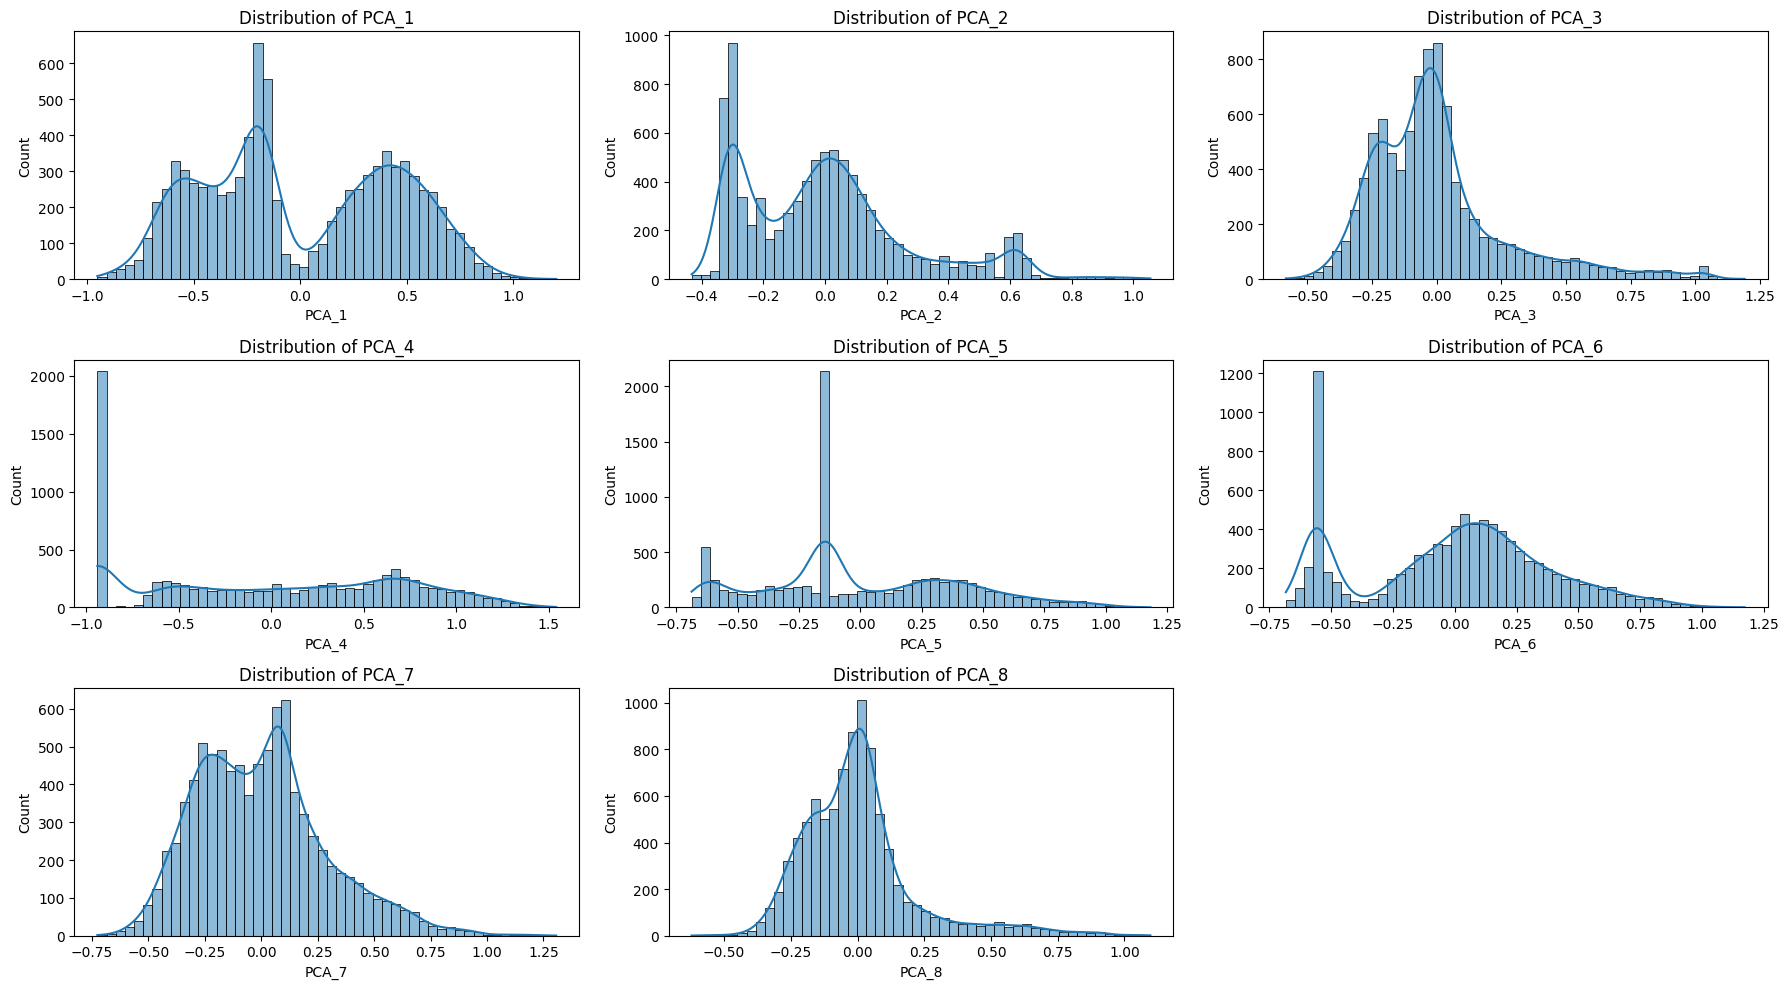

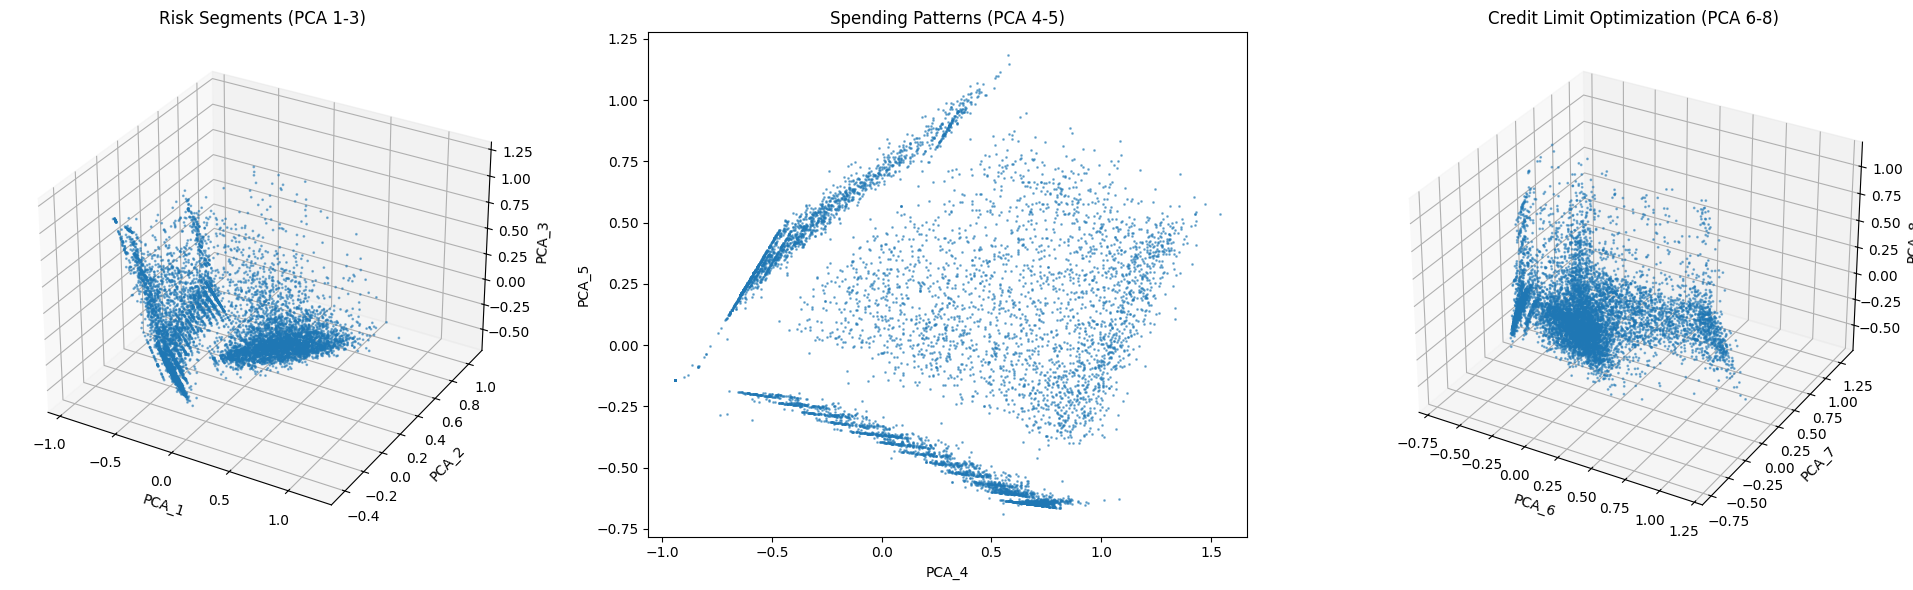

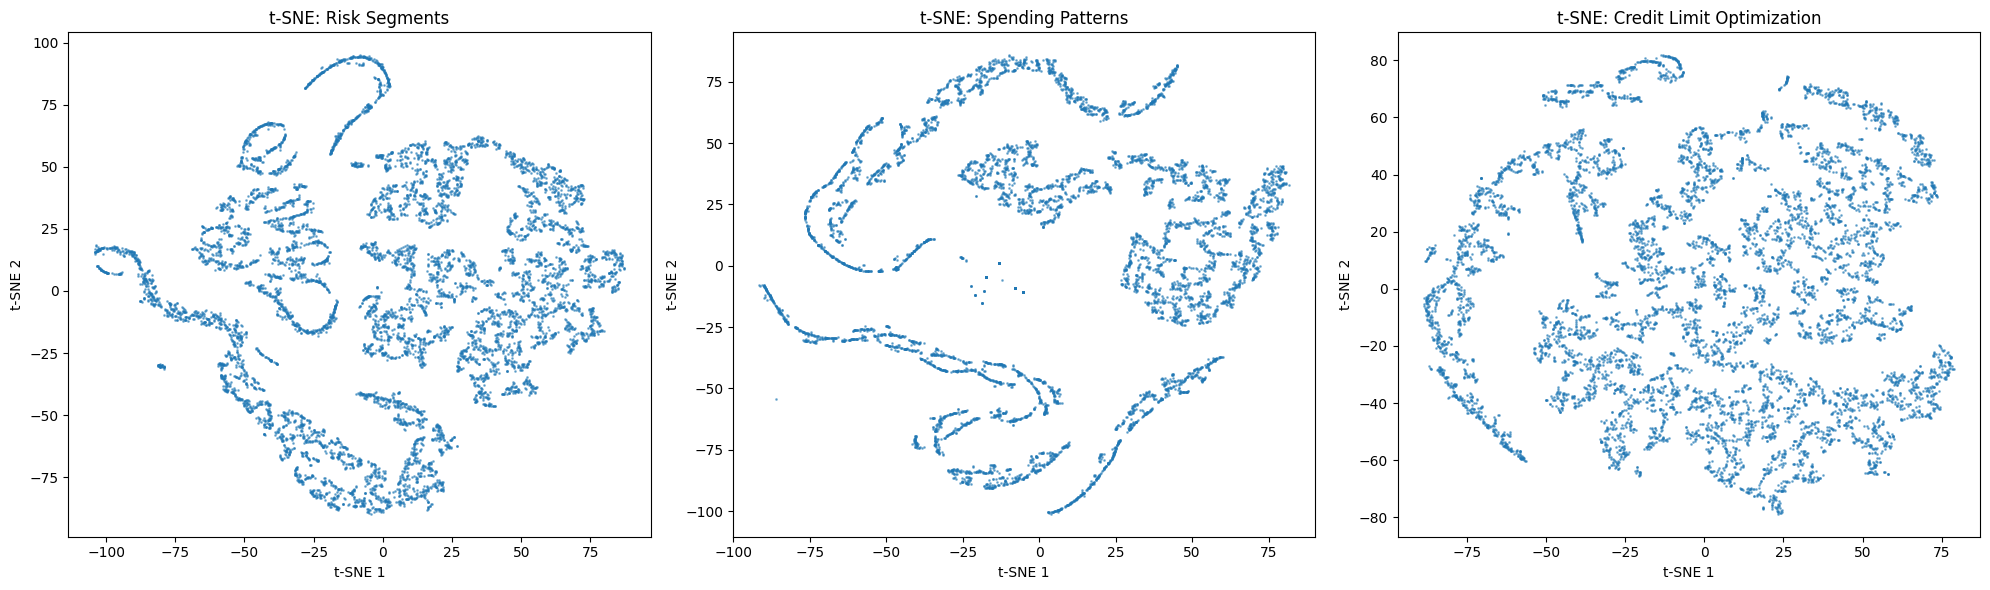


Statistical Summary of Risk Segments:
              PCA_1         PCA_2         PCA_3
count  8.949000e+03  8.949000e+03  8.949000e+03
mean   3.175965e-17  1.190987e-17  1.032189e-16
std    4.498245e-01  2.692483e-01  2.648703e-01
min   -9.522981e-01 -4.325765e-01 -5.834341e-01
25%   -3.707836e-01 -2.369239e-01 -1.800311e-01
50%   -1.356773e-01 -1.823004e-02 -3.944774e-02
75%    4.073443e-01  1.205573e-01  7.284682e-02
max    1.202683e+00  1.055110e+00  1.190410e+00

Statistical Summary of Spending Patterns:
              PCA_4         PCA_5
count  8.949000e+03  8.949000e+03
mean   4.922746e-17  2.699570e-17
std    7.027606e-01  4.016408e-01
min   -9.401104e-01 -6.881725e-01
25%   -6.262634e-01 -2.435099e-01
50%    2.876709e-02 -1.402279e-01
75%    6.321737e-01  3.142654e-01
max    1.541149e+00  1.182909e+00

Statistical Summary of Credit Limit Optimization:
              PCA_6         PCA_7         PCA_8
count  8.949000e+03  8.949000e+03  8.949000e+03
mean  -1.746781e-17  1.270386e-17

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Define PCA groups
risk_segments = ['PCA_1', 'PCA_2', 'PCA_3']
spending_patterns = ['PCA_4', 'PCA_5']
credit_limit_opt = ['PCA_6', 'PCA_7', 'PCA_8']
all_features = risk_segments + spending_patterns + credit_limit_opt

# Print shape information for debugging
print("Data shape verification:")
print(f"DataFrame shape: {df_pca_final.shape}")
for col in all_features:
    print(f"{col} shape: {df_pca_final[col].shape}")

# 1. Distribution Analysis
plt.figure(figsize=(18, 10))
for i, feature in enumerate(all_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_pca_final[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 2. 3D Scatter plots for each group
fig = plt.figure(figsize=(20, 6))

# Convert data to numpy arrays first
risk_data = df_pca_final[risk_segments].to_numpy()
spending_data = df_pca_final[spending_patterns].to_numpy()
credit_data = df_pca_final[credit_limit_opt].to_numpy()

# Risk Segments (PCA 1, 2, 3)
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(risk_data[:, 0],  # PCA_1
            risk_data[:, 1],  # PCA_2
            risk_data[:, 2],  # PCA_3
            alpha=0.5, s=1)
ax1.set_title('Risk Segments (PCA 1-3)')
ax1.set_xlabel('PCA_1')
ax1.set_ylabel('PCA_2')
ax1.set_zlabel('PCA_3')

# Spending Patterns (PCA 4 & 5)
ax2 = fig.add_subplot(132)
ax2.scatter(spending_data[:, 0],  # PCA_4
            spending_data[:, 1],  # PCA_5
            alpha=0.5, s=1)
ax2.set_title('Spending Patterns (PCA 4-5)')
ax2.set_xlabel('PCA_4')
ax2.set_ylabel('PCA_5')

# Credit Limit Optimization (PCA 6, 7, 8)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(credit_data[:, 0],  # PCA_6
            credit_data[:, 1],  # PCA_7
            credit_data[:, 2],  # PCA_8
            alpha=0.5, s=1)
ax3.set_title('Credit Limit Optimization (PCA 6-8)')
ax3.set_xlabel('PCA_6')
ax3.set_ylabel('PCA_7')
ax3.set_zlabel('PCA_8')

plt.tight_layout()
plt.show()

# 3. t-SNE Analysis for each group
groups = [
    ('Risk Segments', risk_data),
    ('Spending Patterns', spending_data),
    ('Credit Limit Optimization', credit_data)
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, (title, data) in enumerate(groups):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data)
    
    axes[i].scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, s=1)
    axes[i].set_title(f't-SNE: {title}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

# 4. Statistical Summary by groups
print("\nStatistical Summary of Risk Segments:")
print(df_pca_final[risk_segments].describe())
print("\nStatistical Summary of Spending Patterns:")
print(df_pca_final[spending_patterns].describe())
print("\nStatistical Summary of Credit Limit Optimization:")
print(df_pca_final[credit_limit_opt].describe())

Visual Analysis:
Distribution plots show multi-modal patterns across all PCAs, with particularly sharp peaks in PCA_4 and PCA_5. Most components show some skewness.

3D/2D scatter plots reveal interesting patterns:
Risk Segments (PCA 1-3): Shows clear clustered structure with multiple density centers
Spending Patterns (PCA 4-5): Exhibits distinct V-shaped pattern with clear linear relationships
Credit Limit Optimization (PCA 6-8): Displays a concentrated core with scattered outliers

t-SNE plots separate the data:
Risk Segments: Shows well-defined, separate clusters of varying sizes
Spending Patterns: Creates smooth, curved structures suggesting continuous patterns
Credit Limit Optimization: Forms a circular pattern with multiple sub-clusters


Risk Segments (PCA 1-3)

1. K-means - Clear cluster centers visible in the scatter plot
2. DBSCAN - Can handle the varying density clusters shown in t-SNE
3. Hierarchical - Good for the nested structure visible in both 3D scatter and t-SNE

Spending Patterns (PCA 4-5)

1. Mean-shift - Can capture the clear density patterns in V-shape
2. DBSCAN - Good for the continuous, density-based structures
3. K-means - Provides stable cluster centers for the linear relationships.

Credit Limit Optimization (PCA 6-8)

1. Birch - Can handle the core-outlier structure efficiently
2. Mean-shift - Good for the natural groupings visible in t-SNE
3. Hierarchical - Can capture the nested sub-clusters shown in t-SNE

# III. Clustering Algorithms

Before we start the model building, we chose three metrics that address different concerns for evaluating clustering models across all three business topics: 

a. Silhouette Score focuses on the overall quality of clustering by examining cohesion and separation.

b. Davies-Bouldin Index emphasizes compactness and distinctness of clusters, ensuring that each segment is specific.

c. Cluster Stability Analysis (ARI) looks at the robustness of clusters, ensuring consistent insights over different samples.

Using these three metrics together provides a comprehensive evaluation of clustering models across all three business contexts. They ensure that the clusters are well-defined, meaningful, and consistent, making them actionable for business decisions.

1. elbow plot for each business topic

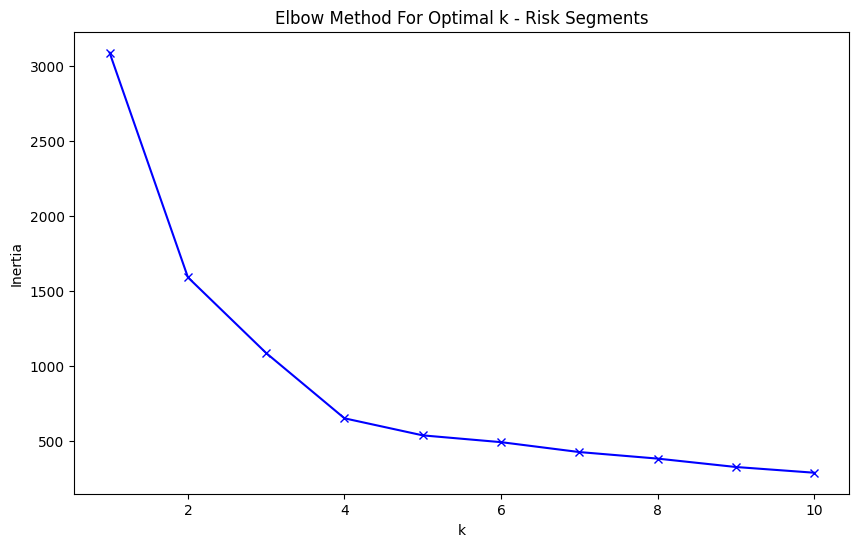


Angles at each k for Risk Segments:
Angle at k=2: 179.92 degrees
Angle at k=3: 179.98 degrees
Angle at k=4: 179.63 degrees
Angle at k=5: 179.24 degrees
Angle at k=6: 179.60 degrees
Angle at k=7: 179.55 degrees
Angle at k=8: 179.71 degrees
Angle at k=9: 179.52 degrees


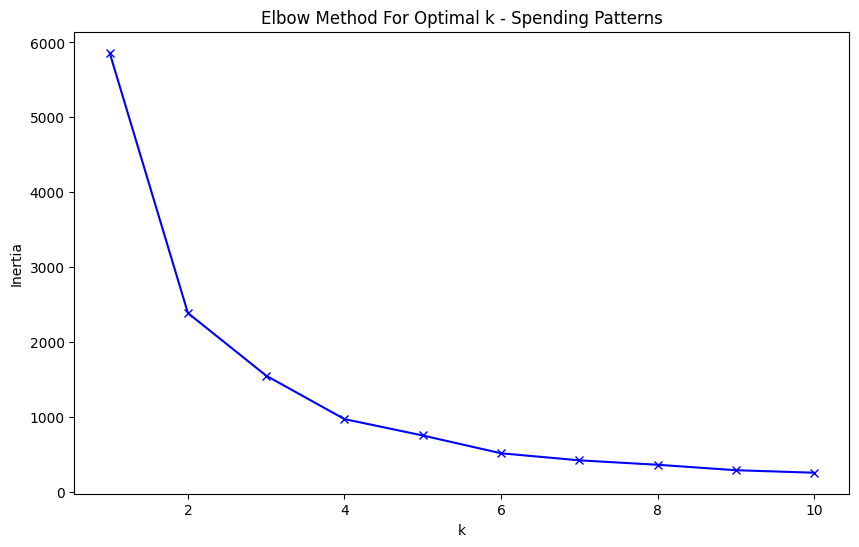


Angles at each k for Spending Patterns:
Angle at k=2: 179.95 degrees
Angle at k=3: 179.97 degrees
Angle at k=4: 179.84 degrees
Angle at k=5: 179.98 degrees
Angle at k=6: 179.63 degrees
Angle at k=7: 179.64 degrees
Angle at k=8: 179.82 degrees
Angle at k=9: 179.08 degrees


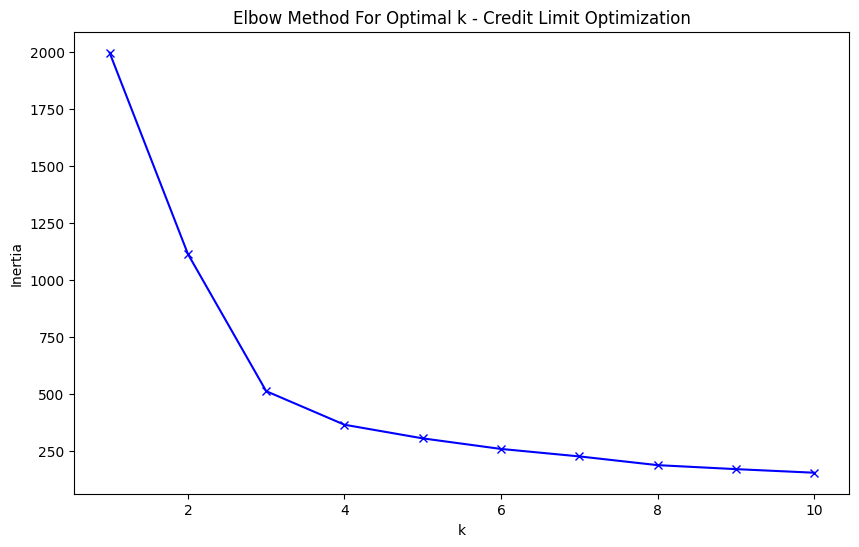


Angles at each k for Credit Limit Optimization:
Angle at k=2: 179.97 degrees
Angle at k=3: 179.71 degrees
Angle at k=4: 179.43 degrees
Angle at k=5: 179.72 degrees
Angle at k=6: 179.49 degrees
Angle at k=7: 179.75 degrees
Angle at k=8: 178.22 degrees
Angle at k=9: 179.64 degrees


In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Function to perform elbow method
def elbow_method(data, max_k=10, title=""):
   inertias = []
   
   for k in range(1, max_k+1):
       kmeans = KMeans(n_clusters=k, random_state=42)
       kmeans.fit(data)
       inertias.append(kmeans.inertia_)
   
   plt.figure(figsize=(10, 6))
   plt.plot(range(1, max_k+1), inertias, 'bx-')
   plt.xlabel('k')
   plt.ylabel('Inertia')
   plt.title(f'Elbow Method For Optimal k - {title}')
   plt.show()
   
   # Calculate the angle at each point
   angles = []
   for i in range(1, len(inertias)-1):
       pt1 = np.array([i-1, inertias[i-1]])
       pt2 = np.array([i, inertias[i]])
       pt3 = np.array([i+1, inertias[i+1]])
       
       v1 = pt1 - pt2
       v2 = pt3 - pt2
       
       angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
       angles.append(angle)
   
   print(f"\nAngles at each k for {title}:")
   for k, angle in enumerate(angles, 2):
       print(f"Angle at k={k}: {angle:.2f} degrees")

# Perform elbow method for each business topic
# Topic 1: Risk Segments (PCA 1, 2, 3)
risk_data = df_pca_final[['PCA_1', 'PCA_2', 'PCA_3']]
elbow_method(risk_data, title="Risk Segments")

# Topic 2: Spending Patterns (PCA 4, 5)
spending_data = df_pca_final[['PCA_4', 'PCA_5']]
elbow_method(spending_data, title="Spending Patterns")

# Topic 3: Credit Limit Optimization (PCA 6, 7)
credit_data = df_pca_final[['PCA_6', 'PCA_7']]
elbow_method(credit_data, title="Credit Limit Optimization")

Elbow Method Analysis for Risk Segments and Spending Patterns

**Risk Segments (PCA_1, PCA_2, PCA_3) and Spending Patterns (PCA_4, PCA_5)** both utilized K-means clustering, with initial observations suggesting potential optimal cluster numbers:

- **Risk Segments (k=4):**
  - The elbow curve shows a sharp bend at \( k=4 \).
  - The rate of inertia decrease significantly slows after \( k=4 \).
  - Inertia drops from ~3000 to ~500 at \( k=4 \), then flattens, providing a good balance between complexity and interpretation.

- **Spending Patterns (k=4):**
  - The elbow curve indicates a potential bend at \( k=4 \).
  - This cluster count captures more nuances in spending behaviors, offering finer segmentation.
  - The initial selection aims to balance capturing diversity in spending patterns and avoiding overfitting.

**Note**: The selection of these numbers (\( k=4 \) for Risk Segments and \( k=4 \) for Spending Patterns) was based on visual assessments of the elbow plots. However, these choices serve as starting points. The actual number of clusters used in the final models will be determined by systematic evaluations and scoring metrics in subsequent parts of the code.

**Credit Limit Optimization (PCA_6, PCA_7):**
- Using methods like Birch and Mean-shift to adapt to the structure of the data.
- These algorithms do not require pre-specifying the number of clusters, allowing for dynamic identification of natural groupings.

**In summary**, while visual analyses guide the initial selection of cluster numbers, the final models rely on rigorous evaluation metrics to ensure that the selected cluster count optimally reflects the underlying data patterns.


2. Clustering for High-Risk Customer Segments 

k=2, Silhouette Score=0.490
k=3, Silhouette Score=0.500
k=4, Silhouette Score=0.567
k=5, Silhouette Score=0.468
k=6, Silhouette Score=0.475
k=7, Silhouette Score=0.488
k=8, Silhouette Score=0.434
k=9, Silhouette Score=0.420
k=10, Silhouette Score=0.431

Best number of clusters for K-means: 4


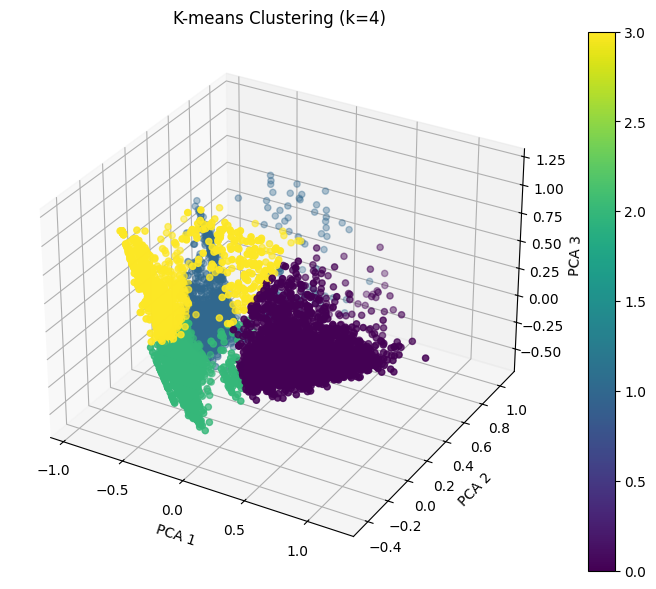


K-means metrics:
Clusters: 4
Silhouette Score: 0.567
Davies-Bouldin Index: 0.640


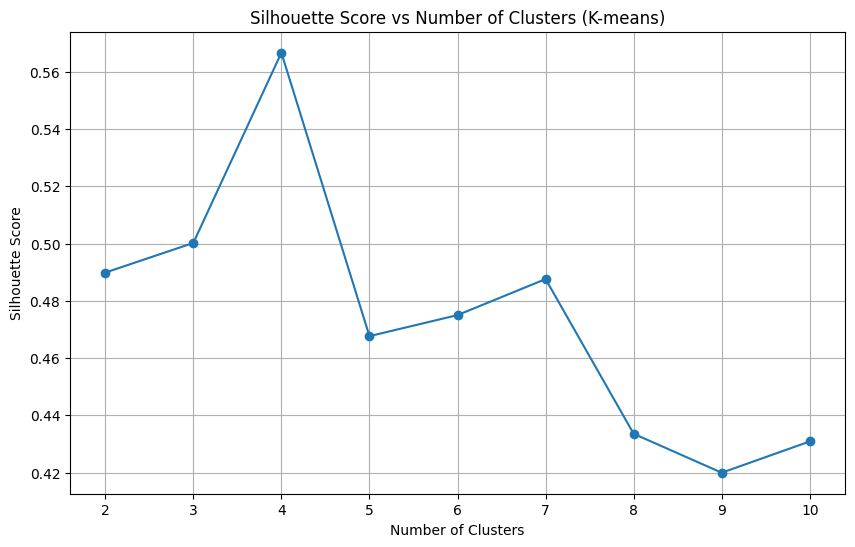


All valid DBSCAN results:
eps=0.1, min_samples=20, n_clusters=2, silhouette=0.448
eps=0.2, min_samples=5, n_clusters=3, silhouette=0.445
eps=0.2, min_samples=15, n_clusters=3, silhouette=0.444
eps=0.2, min_samples=10, n_clusters=3, silhouette=0.442
eps=0.1, min_samples=15, n_clusters=3, silhouette=0.423
eps=0.2, min_samples=20, n_clusters=3, silhouette=0.419
eps=0.1, min_samples=10, n_clusters=4, silhouette=0.408
eps=0.1, min_samples=5, n_clusters=10, silhouette=0.223

Selected DBSCAN parameters:
eps=0.1, min_samples=20, n_clusters=2


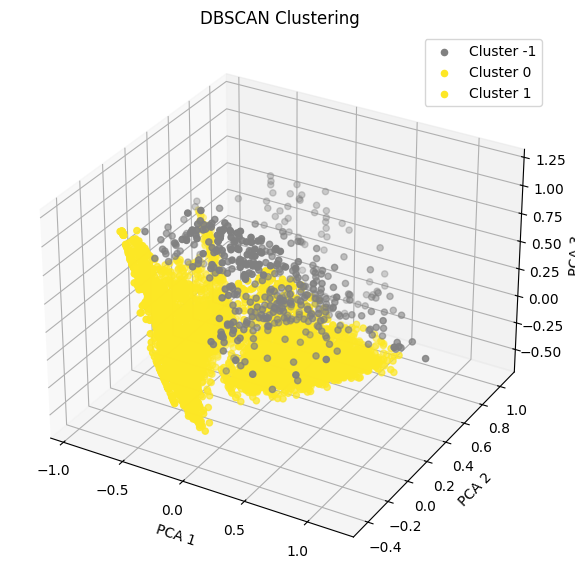


DBSCAN metrics:
Clusters: 2
Silhouette Score: 0.448
Davies-Bouldin Index: 1.358


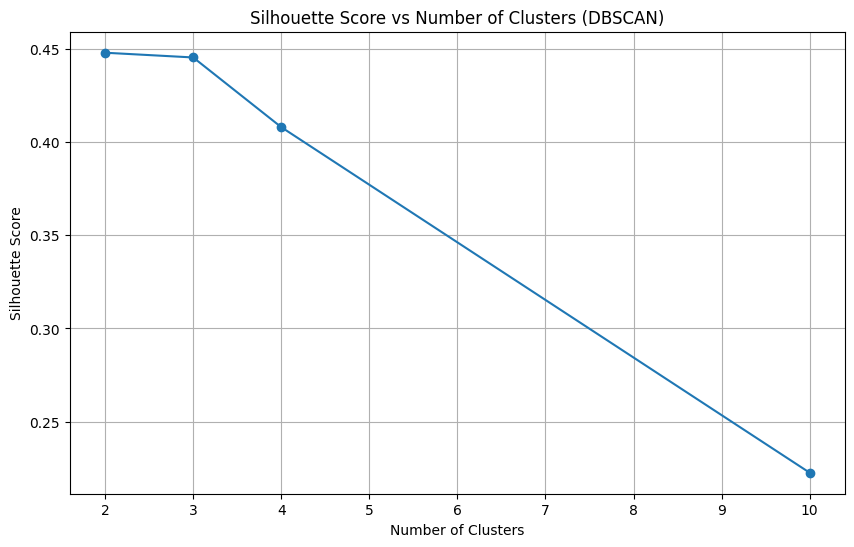

k=2, Silhouette Score=0.485
k=3, Silhouette Score=0.505
k=4, Silhouette Score=0.538
k=5, Silhouette Score=0.430
k=6, Silhouette Score=0.444
k=7, Silhouette Score=0.418
k=8, Silhouette Score=0.415
k=9, Silhouette Score=0.426
k=10, Silhouette Score=0.427

Best number of clusters for Agglomerative Clustering: 4


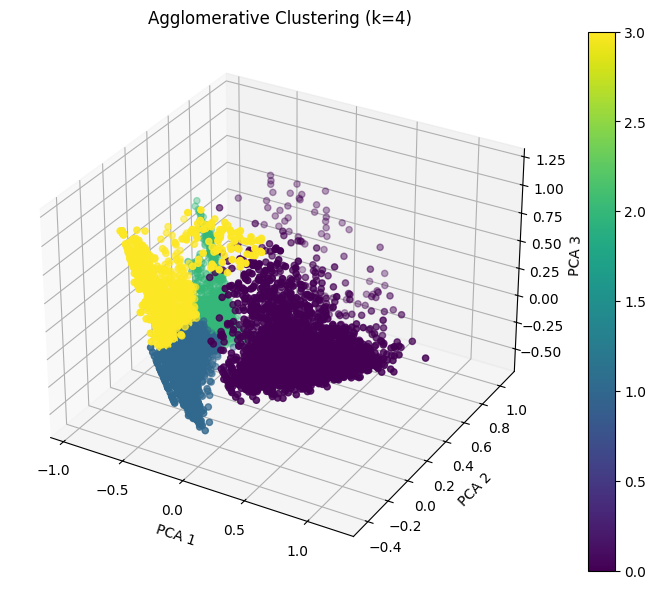


Agglomerative metrics:
Clusters: 4
Silhouette Score: 0.538
Davies-Bouldin Index: 0.630


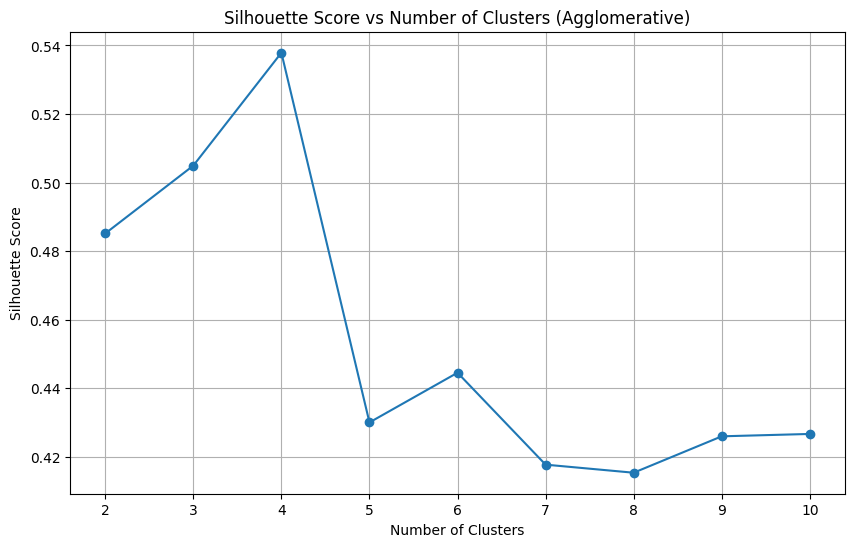


Execution Times:
K-means: 16.34 seconds
DBSCAN: 25.26 seconds
Agglomerative: 42.94 seconds


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
import time
import seaborn as sns

# Prepare data
risk_data = df_pca_final[['PCA_1', 'PCA_2', 'PCA_3']]

def plot_3d_clusters(data, labels, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # If it's DBSCAN results (containing -1 for noise)
    if -1 in labels:
        unique_labels = np.unique(labels)
        colors = ['gray' if l == -1 else plt.cm.viridis(i / (len(unique_labels) - 2)) 
                  for i, l in enumerate(unique_labels)]
        
        for label, color in zip(unique_labels, colors):
            mask = labels == label
            ax.scatter(data.loc[mask, 'PCA_1'], 
                       data.loc[mask, 'PCA_2'], 
                       data.loc[mask, 'PCA_3'],
                       c=[color], label=f'Cluster {label}')
        ax.legend()
    else:
        scatter = ax.scatter(data['PCA_1'], data['PCA_2'], data['PCA_3'], 
                             c=labels, cmap='viridis')
        plt.colorbar(scatter)
    
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    plt.title(title)
    plt.show()

def plot_silhouette_comparison(x_values, scores, title, xlabel='Number of Clusters'):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, scores, marker='o')
    plt.title(f'Silhouette Score vs {xlabel} ({title})')
    plt.xlabel(xlabel)
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

def evaluate_clustering(data, labels, model_name):
    n_clusters = len(np.unique(labels[labels >= 0]))
    if n_clusters < 2:
        print(f"\n{model_name}: Only {n_clusters} cluster found.")
        return None
    
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    print(f"\n{model_name} metrics:")
    print(f"Clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    return silhouette

def plot_colored_dendrogram(linkage_matrix, n_clusters):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, color_threshold=linkage_matrix[-n_clusters + 1, 2])
    plt.title(f'Hierarchical Clustering Dendrogram (n_clusters={n_clusters})')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

# 1. K-means Analysis with automatic selection of best k
start_time = time.time()
silhouette_scores_kmeans = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(risk_data)
    silhouette = silhouette_score(risk_data, labels)
    silhouette_scores_kmeans.append(silhouette)
    print(f"k={n_clusters}, Silhouette Score={silhouette:.3f}")

# Determine the best number of clusters based on the highest silhouette score
best_k = n_clusters_range[np.argmax(silhouette_scores_kmeans)]
print(f"\nBest number of clusters for K-means: {best_k}")

# Final K-means with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(risk_data)
plot_3d_clusters(risk_data, kmeans_labels, f'K-means Clustering (k={best_k})')
evaluate_clustering(risk_data, kmeans_labels, 'K-means')
plot_silhouette_comparison(n_clusters_range, silhouette_scores_kmeans, 'K-means')
kmeans_time = time.time() - start_time

# 2. DBSCAN Analysis with eps and min_samples tuning
start_time = time.time()
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [5, 10, 15, 20]
all_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(risk_data)
        n_clusters = len(np.unique(labels[labels >= 0]))
        
        if n_clusters >= 2:
            silhouette = silhouette_score(risk_data, labels)
            all_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'labels': labels
            })

if all_results:
    all_results.sort(key=lambda x: x['silhouette'], reverse=True)
    best_result = all_results[0]
    
    print("\nAll valid DBSCAN results:")
    for result in all_results:
        print(f"eps={result['eps']}, min_samples={result['min_samples']}, "
              f"n_clusters={result['n_clusters']}, silhouette={result['silhouette']:.3f}")
    
    print(f"\nSelected DBSCAN parameters:")
    print(f"eps={best_result['eps']}, min_samples={best_result['min_samples']}, "
          f"n_clusters={best_result['n_clusters']}")
    
    plot_3d_clusters(risk_data, best_result['labels'], 'DBSCAN Clustering')
    evaluate_clustering(risk_data, best_result['labels'], 'DBSCAN')

    dbscan_cluster_scores = {}
    for result in all_results:
        n = result['n_clusters']
        if n not in dbscan_cluster_scores or result['silhouette'] > dbscan_cluster_scores[n]:
            dbscan_cluster_scores[n] = result['silhouette']
    
    dbscan_clusters = sorted(dbscan_cluster_scores.keys())
    dbscan_scores = [dbscan_cluster_scores[k] for k in dbscan_clusters]
    
    plot_silhouette_comparison(dbscan_clusters, dbscan_scores, 'DBSCAN', xlabel='Number of Clusters')

dbscan_time = time.time() - start_time

# 3. Agglomerative Clustering with n_clusters tuning
start_time = time.time()
linkage_matrix = linkage(risk_data, method='ward')
silhouette_scores_hierarchical = []

for n_clusters in n_clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hierarchical.fit_predict(risk_data)
    silhouette_scores_hierarchical.append(silhouette_score(risk_data, labels))
    print(f"k={n_clusters}, Silhouette Score={silhouette_scores_hierarchical[-1]:.3f}")

optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores_hierarchical)]
print(f"\nBest number of clusters for Agglomerative Clustering: {optimal_n_clusters}")

# Final Agglomerative Clustering with optimal clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_n_clusters)
hierarchical_labels = hierarchical.fit_predict(risk_data)
plot_3d_clusters(risk_data, hierarchical_labels, f'Agglomerative Clustering (k={optimal_n_clusters})')
evaluate_clustering(risk_data, hierarchical_labels, 'Agglomerative')
plot_silhouette_comparison(n_clusters_range, silhouette_scores_hierarchical, 'Agglomerative')
hierarchical_time = time.time() - start_time

# Print execution times
print("\nExecution Times:")
print(f"K-means: {kmeans_time:.2f} seconds")
print(f"DBSCAN: {dbscan_time:.2f} seconds")
print(f"Agglomerative: {hierarchical_time:.2f} seconds")

3. Clustering for Customer Spending Patterns

Min Cluster Size=20, Clusters=15, Silhouette=0.284
Min Cluster Size=30, Clusters=5, Silhouette=0.443
Min Cluster Size=40, Clusters=5, Silhouette=0.449
Min Cluster Size=50, Clusters=5, Silhouette=0.449


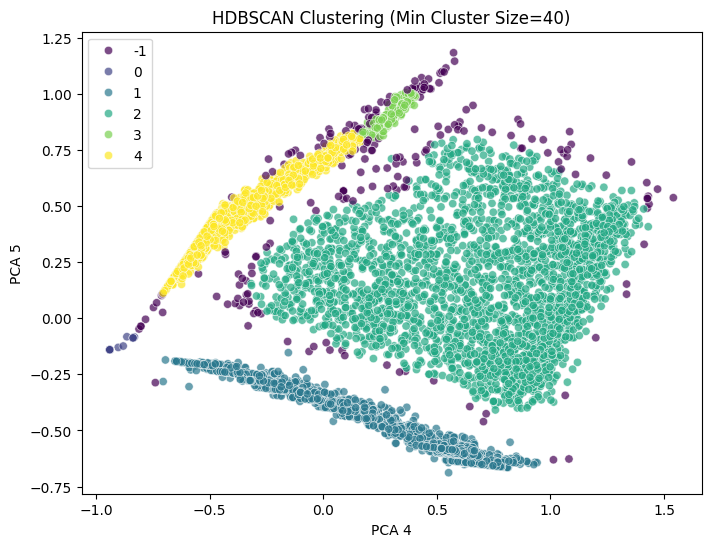


HDBSCAN metrics:
Clusters: 5
Silhouette Score: 0.449
Davies-Bouldin Index: 1.374


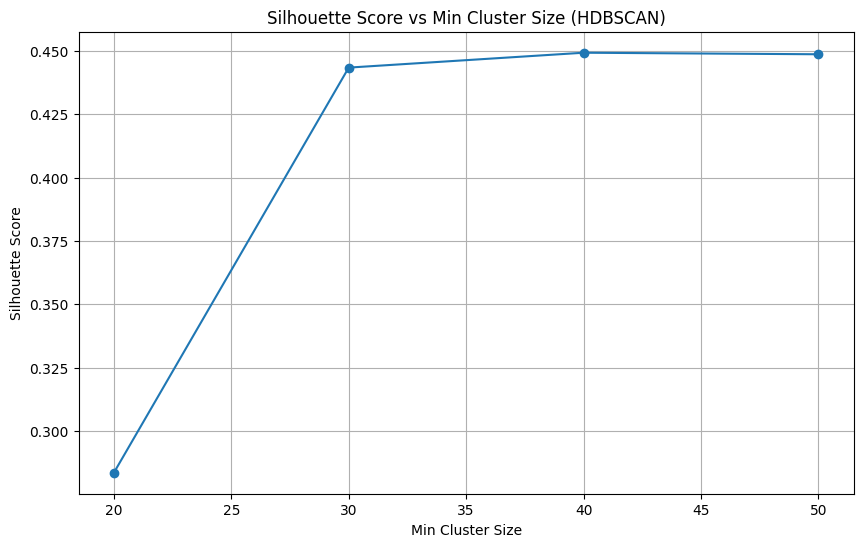


All valid DBSCAN results:
eps=0.1, min_samples=25, n_clusters=4, silhouette=0.450
eps=0.1, min_samples=28, n_clusters=4, silhouette=0.450
eps=0.1, min_samples=22, n_clusters=4, silhouette=0.441

Selected DBSCAN parameters:
eps=0.1, min_samples=25, n_clusters=4


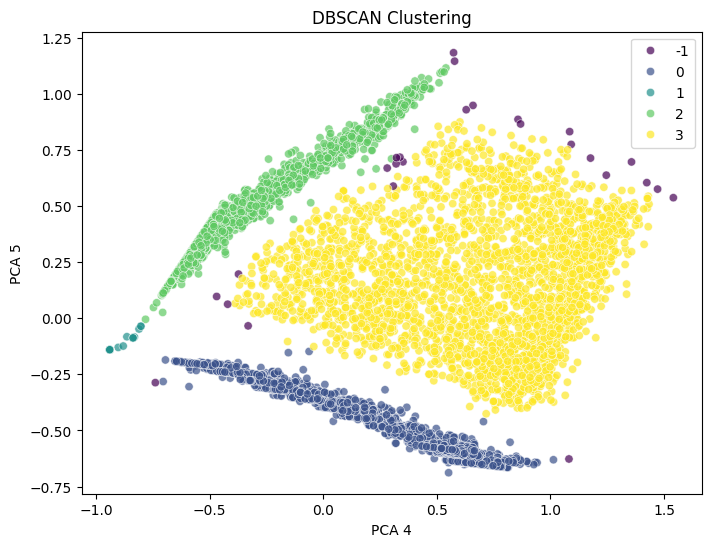


DBSCAN metrics:
Clusters: 4
Silhouette Score: 0.450
Davies-Bouldin Index: 1.615


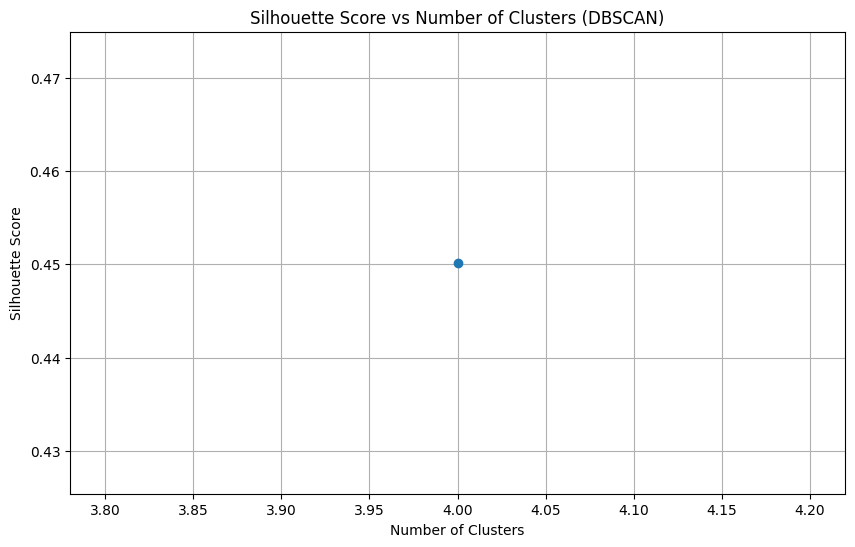

k=2, Silhouette Score=0.524
k=3, Silhouette Score=0.506
k=4, Silhouette Score=0.524
k=5, Silhouette Score=0.540
k=6, Silhouette Score=0.580
k=7, Silhouette Score=0.599
k=8, Silhouette Score=0.573
k=9, Silhouette Score=0.593
k=10, Silhouette Score=0.593

Best number of clusters for K-means: 7


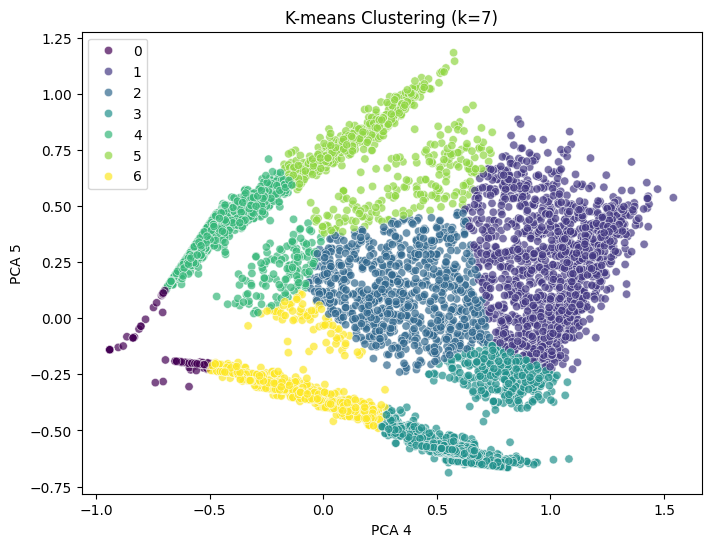


K-means metrics:
Clusters: 7
Silhouette Score: 0.599
Davies-Bouldin Index: 0.645


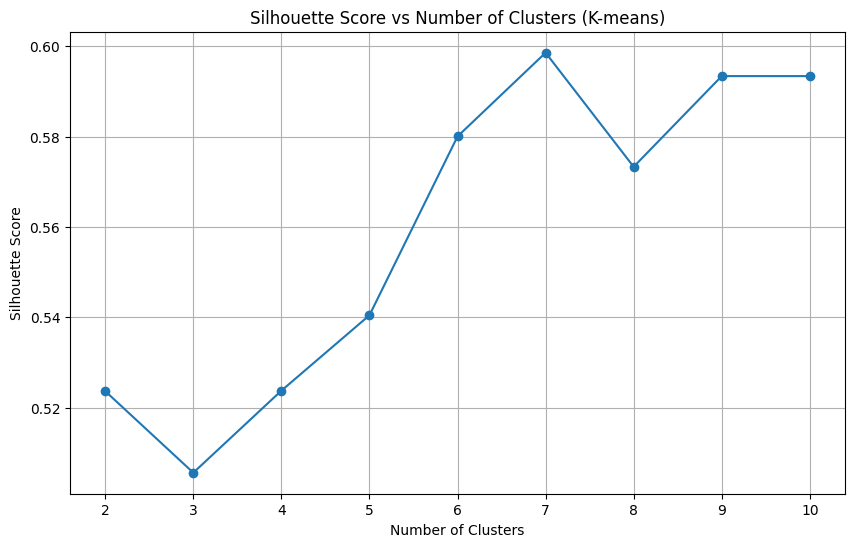


Execution Times:
HDBSCAN: 10.21 seconds
DBSCAN: 13.57 seconds
K-means: 17.03 seconds


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import time

# Prepare data for Business Topic 2 (PCA 4 & 5)
spending_data = df_pca_final[['PCA_4', 'PCA_5']]

def plot_2d_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data['PCA_4'], y=data['PCA_5'], hue=labels, palette='viridis', legend='full', alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA 4')
    plt.ylabel('PCA 5')
    plt.show()

def evaluate_clustering(data, labels, model_name):
    n_clusters = len(np.unique(labels[labels >= 0]))
    if n_clusters < 2:
        print(f"\n{model_name}: Only {n_clusters} cluster found.")
        return None
    
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    print(f"\n{model_name} metrics:")
    print(f"Clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    return silhouette

def plot_silhouette_comparison(x_values, scores, title, xlabel='Number of Clusters'):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, scores, marker='o')
    plt.title(f'Silhouette Score vs {xlabel} ({title})')
    plt.xlabel(xlabel)
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# 1. HDBSCAN Analysis with min_cluster_size Tuning
start_time = time.time()
min_cluster_size_values = [20, 30, 40, 50]  # Adjusted range for quicker testing
hdbscan_scores = []

for min_cluster_size in min_cluster_size_values:
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
    labels = hdbscan.fit_predict(spending_data)
    n_clusters = len(np.unique(labels[labels >= 0]))
    
    if n_clusters >= 2:
        silhouette = silhouette_score(spending_data, labels)
        hdbscan_scores.append(silhouette)
        print(f"Min Cluster Size={min_cluster_size}, Clusters={n_clusters}, Silhouette={silhouette:.3f}")

# Select the best min_cluster_size based on silhouette score
best_min_cluster_size_idx = np.argmax(hdbscan_scores)
best_min_cluster_size = min_cluster_size_values[best_min_cluster_size_idx]

# Run HDBSCAN with the best min_cluster_size
hdbscan = HDBSCAN(min_cluster_size=best_min_cluster_size)
hdbscan_labels = hdbscan.fit_predict(spending_data)
plot_2d_clusters(spending_data, hdbscan_labels, f'HDBSCAN Clustering (Min Cluster Size={best_min_cluster_size})')
evaluate_clustering(spending_data, hdbscan_labels, 'HDBSCAN')

# Plot HDBSCAN min_cluster_size vs silhouette score
plot_silhouette_comparison(min_cluster_size_values, hdbscan_scores, 'HDBSCAN', xlabel='Min Cluster Size')
hdbscan_time = time.time() - start_time

# 2. DBSCAN Analysis
start_time = time.time()
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [22, 25, 28]
all_dbscan_results = []

# Try all parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(spending_data)
        n_clusters = len(np.unique(labels[labels >= 0]))
        
        if n_clusters >= 2:
            silhouette = silhouette_score(spending_data, labels)
            all_dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'labels': labels
            })

if all_dbscan_results:
    # Sort by silhouette score
    all_dbscan_results.sort(key=lambda x: x['silhouette'], reverse=True)
    best_dbscan_result = all_dbscan_results[0]
    
    print("\nAll valid DBSCAN results:")
    for result in all_dbscan_results:
        print(f"eps={result['eps']}, min_samples={result['min_samples']}, "
              f"n_clusters={result['n_clusters']}, silhouette={result['silhouette']:.3f}")
    
    print(f"\nSelected DBSCAN parameters:")
    print(f"eps={best_dbscan_result['eps']}, min_samples={best_dbscan_result['min_samples']}, "
          f"n_clusters={best_dbscan_result['n_clusters']}")
    
    plot_2d_clusters(spending_data, best_dbscan_result['labels'], 'DBSCAN Clustering')
    evaluate_clustering(spending_data, best_dbscan_result['labels'], 'DBSCAN')

    # Plot silhouette scores for different numbers of clusters
    dbscan_cluster_scores = {}
    for result in all_dbscan_results:
        n = result['n_clusters']
        if n not in dbscan_cluster_scores or result['silhouette'] > dbscan_cluster_scores[n]:
            dbscan_cluster_scores[n] = result['silhouette']
    
    dbscan_clusters = sorted(dbscan_cluster_scores.keys())
    dbscan_scores = [dbscan_cluster_scores[k] for k in dbscan_clusters]
    
    plot_silhouette_comparison(dbscan_clusters, dbscan_scores, 'DBSCAN')

dbscan_time = time.time() - start_time

# 3. K-means Analysis with automatic selection of best k
start_time = time.time()
silhouette_scores_kmeans = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(spending_data)
    silhouette = silhouette_score(spending_data, labels)
    silhouette_scores_kmeans.append(silhouette)
    print(f"k={n_clusters}, Silhouette Score={silhouette:.3f}")

# Determine the best number of clusters based on the highest silhouette score
best_k = n_clusters_range[np.argmax(silhouette_scores_kmeans)]
print(f"\nBest number of clusters for K-means: {best_k}")

# Final K-means with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(spending_data)
plot_2d_clusters(spending_data, kmeans_labels, f'K-means Clustering (k={best_k})')
evaluate_clustering(spending_data, kmeans_labels, 'K-means')

# Plot K-means silhouette comparison
plot_silhouette_comparison(n_clusters_range, silhouette_scores_kmeans, 'K-means')
kmeans_time = time.time() - start_time

# Print execution times
print("\nExecution Times:")
print(f"HDBSCAN: {hdbscan_time:.2f} seconds")
print(f"DBSCAN: {dbscan_time:.2f} seconds")
print(f"K-means: {kmeans_time:.2f} seconds")

4. Clustering for Credit Limit Optimization

Min Cluster Size=20, Clusters=5, Silhouette=-0.009
Min Cluster Size=25, Clusters=8, Silhouette=-0.040
Min Cluster Size=30, Clusters=6, Silhouette=0.110
Min Cluster Size=35, Clusters=6, Silhouette=0.067
Min Cluster Size=40, Clusters=4, Silhouette=0.047


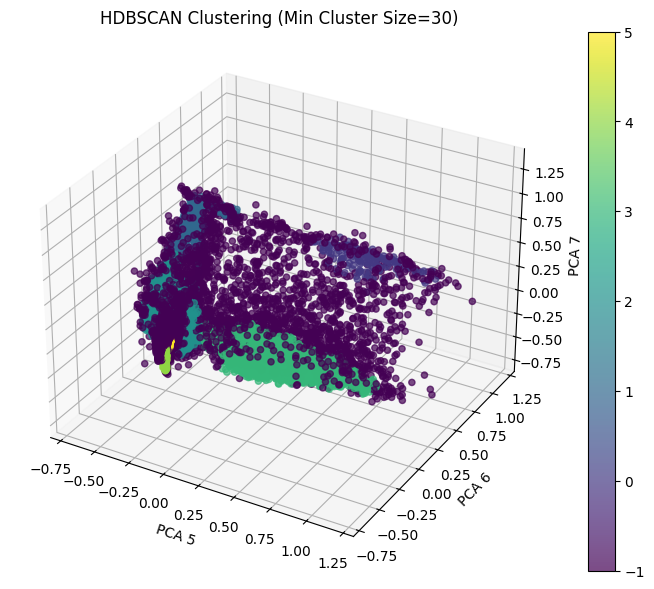


HDBSCAN metrics:
Clusters: 6
Silhouette Score: 0.110
Davies-Bouldin Index: 1.419


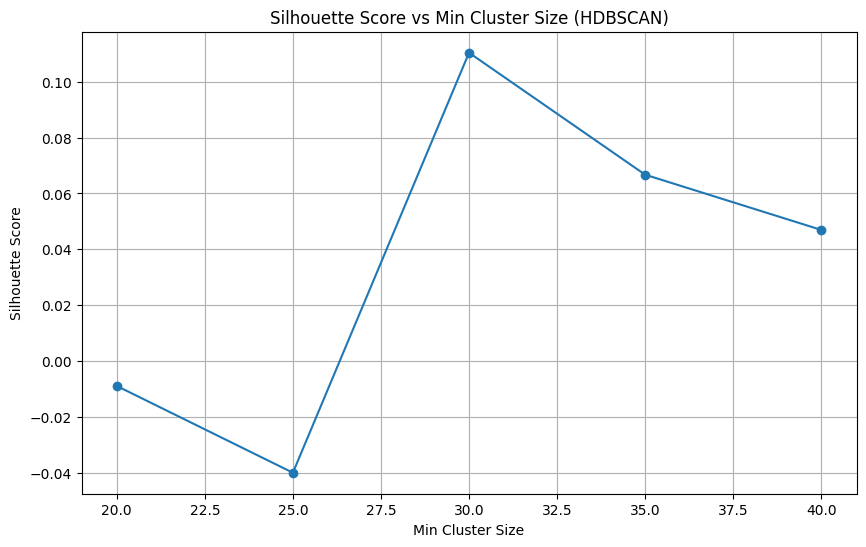

Bandwidth=0.35, Clusters=7, Silhouette=0.449
Bandwidth=0.40, Clusters=6, Silhouette=0.453
Bandwidth=0.45, Clusters=4, Silhouette=0.446


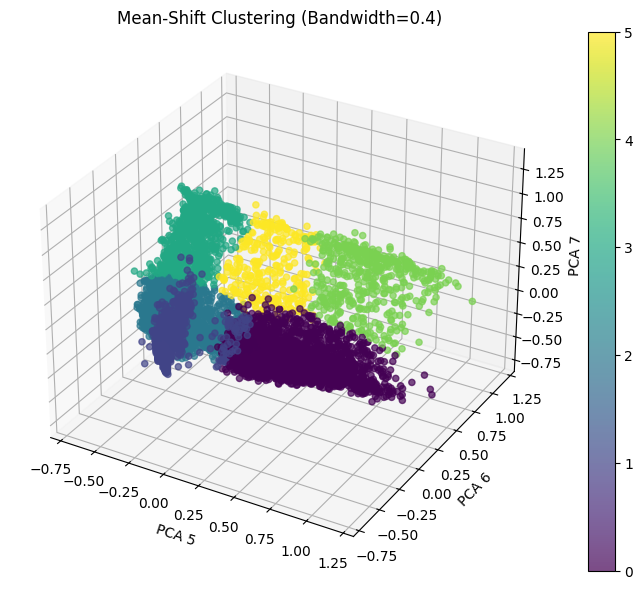


Mean-Shift metrics:
Clusters: 6
Silhouette Score: 0.453
Davies-Bouldin Index: 0.926


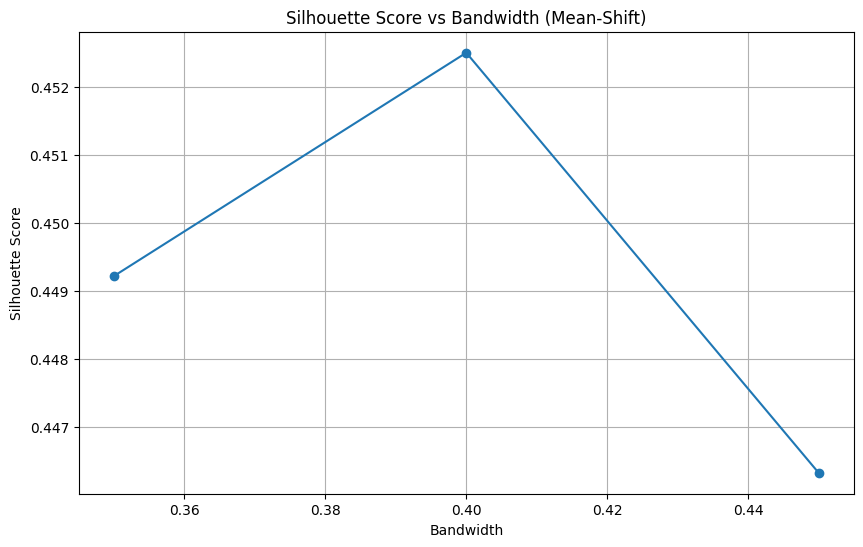

K-means with k=2, Silhouette Score=0.370
K-means with k=3, Silhouette Score=0.428
K-means with k=4, Silhouette Score=0.442
K-means with k=5, Silhouette Score=0.464
K-means with k=6, Silhouette Score=0.442
K-means with k=7, Silhouette Score=0.452
K-means with k=8, Silhouette Score=0.429
K-means with k=9, Silhouette Score=0.424
K-means with k=10, Silhouette Score=0.425


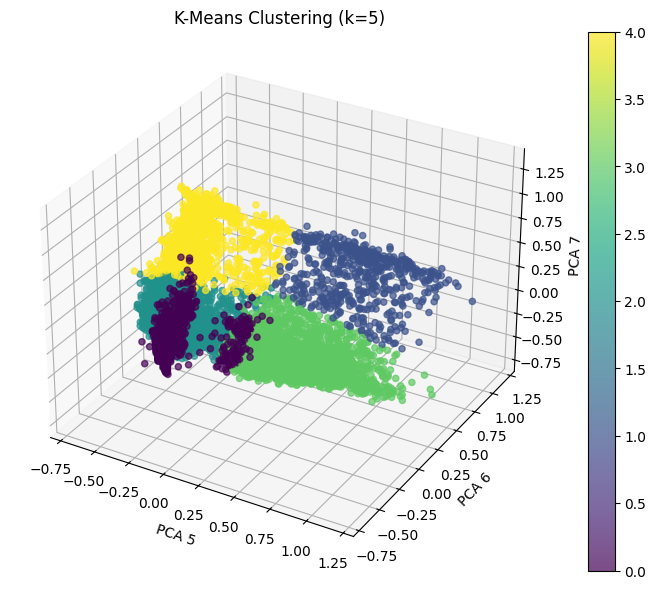


K-means metrics:
Clusters: 5
Silhouette Score: 0.464
Davies-Bouldin Index: 0.815


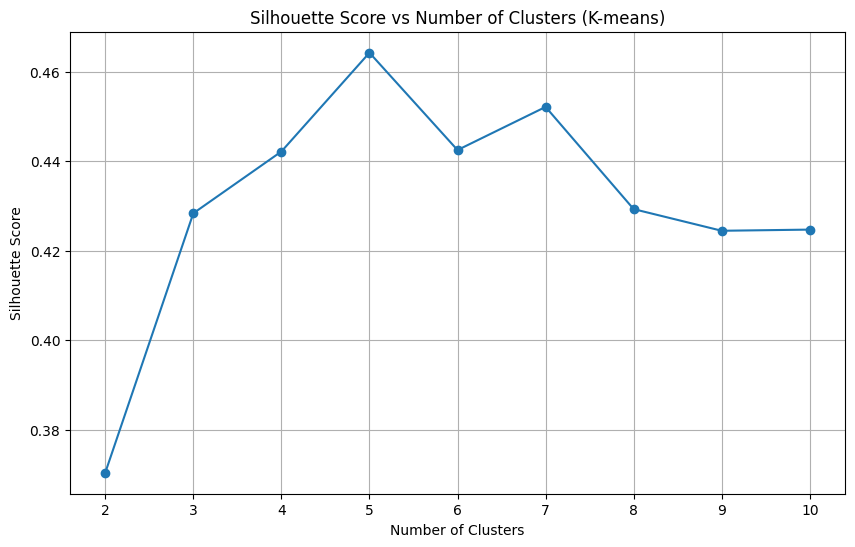


Execution Times:
HDBSCAN: 11.08 seconds
Mean-Shift: 180.78 seconds
K-means: 18.23 seconds


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from sklearn.cluster import MeanShift, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
import time
import seaborn as sns

# Prepare data for Business Topic 3 (PCA 5, PCA 6, PCA 7)
credit_limit_data = df_pca_final[['PCA_5', 'PCA_6', 'PCA_7']]

def plot_3d_clusters(data, labels, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data['PCA_5'], data['PCA_6'], data['PCA_7'], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    ax.set_xlabel('PCA 5')
    ax.set_ylabel('PCA 6')
    ax.set_zlabel('PCA 7')
    plt.title(title)
    plt.show()

def plot_silhouette_comparison(x_values, scores, title, xlabel='Number of Clusters'):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, scores, marker='o')
    plt.title(f'Silhouette Score vs {xlabel} ({title})')
    plt.xlabel(xlabel)
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

def evaluate_clustering(data, labels, model_name):
    n_clusters = len(np.unique(labels[labels >= 0]))
    if n_clusters < 2:
        print(f"\n{model_name}: Only {n_clusters} cluster found.")
        return None
    
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    print(f"\n{model_name} metrics:")
    print(f"Clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    return silhouette

# 1. HDBSCAN Analysis with min_cluster_size Tuning
start_time = time.time()
min_cluster_size_values = [20, 25, 30, 35, 40] 
hdbscan_scores = []

for min_cluster_size in min_cluster_size_values:
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
    labels = hdbscan.fit_predict(credit_limit_data)
    n_clusters = len(np.unique(labels[labels >= 0]))
    
    if n_clusters >= 2:
        silhouette = silhouette_score(credit_limit_data, labels)
        hdbscan_scores.append(silhouette)
        
        print(f"Min Cluster Size={min_cluster_size}, Clusters={n_clusters}, Silhouette={silhouette:.3f}")

# Select the best min_cluster_size based on silhouette score
best_min_cluster_size_idx = np.argmax(hdbscan_scores)
best_min_cluster_size = min_cluster_size_values[best_min_cluster_size_idx]

# Run HDBSCAN with the best min_cluster_size
hdbscan = HDBSCAN(min_cluster_size=best_min_cluster_size)
hdbscan_labels = hdbscan.fit_predict(credit_limit_data)
plot_3d_clusters(credit_limit_data, hdbscan_labels, f'HDBSCAN Clustering (Min Cluster Size={best_min_cluster_size})')
evaluate_clustering(credit_limit_data, hdbscan_labels, 'HDBSCAN')

# Plot HDBSCAN min_cluster_size vs silhouette score
plot_silhouette_comparison(min_cluster_size_values, hdbscan_scores, 'HDBSCAN', xlabel='Min Cluster Size')
hdbscan_time = time.time() - start_time

# 2. Mean-Shift Analysis with Simplified Bandwidth Tuning
start_time = time.time()
bandwidth_values = [0.35, 0.4, 0.45]  
mean_shift_scores = []
mean_shift_cluster_counts = []

for bandwidth in bandwidth_values:
    mean_shift = MeanShift(bandwidth=bandwidth)
    labels = mean_shift.fit_predict(credit_limit_data)
    n_clusters = len(np.unique(labels[labels >= 0]))
    
    if n_clusters >= 2:
        silhouette = silhouette_score(credit_limit_data, labels)
        mean_shift_scores.append(silhouette)
        mean_shift_cluster_counts.append(n_clusters)
        
        print(f"Bandwidth={bandwidth:.2f}, Clusters={n_clusters}, Silhouette={silhouette:.3f}")

# Select the best bandwidth based on the silhouette score
best_bandwidth_idx = np.argmax(mean_shift_scores)
best_bandwidth = bandwidth_values[best_bandwidth_idx]

# Run Mean-Shift with the best bandwidth
mean_shift = MeanShift(bandwidth=best_bandwidth)
mean_shift_labels = mean_shift.fit_predict(credit_limit_data)
plot_3d_clusters(credit_limit_data, mean_shift_labels, f'Mean-Shift Clustering (Bandwidth={best_bandwidth})')
evaluate_clustering(credit_limit_data, mean_shift_labels, 'Mean-Shift')

# Plot Mean-Shift silhouette comparison
plot_silhouette_comparison(bandwidth_values, mean_shift_scores, 'Mean-Shift', xlabel='Bandwidth')
mean_shift_time = time.time() - start_time

# 3. K-Means Analysis with k tuning
start_time = time.time()
n_clusters_range = range(2, 11)
silhouette_scores_kmeans = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(credit_limit_data)
    silhouette = silhouette_score(credit_limit_data, labels)
    silhouette_scores_kmeans.append(silhouette)
    print(f"K-means with k={n_clusters}, Silhouette Score={silhouette:.3f}")

# Select the best number of clusters based on the silhouette score
best_n_clusters_idx = np.argmax(silhouette_scores_kmeans)
best_n_clusters = n_clusters_range[best_n_clusters_idx]

# Run K-Means with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(credit_limit_data)
plot_3d_clusters(credit_limit_data, kmeans_labels, f'K-Means Clustering (k={best_n_clusters})')
evaluate_clustering(credit_limit_data, kmeans_labels, 'K-means')

# Plot K-means silhouette comparison
plot_silhouette_comparison(n_clusters_range, silhouette_scores_kmeans, 'K-means')
kmeans_time = time.time() - start_time

# Print execution times
print("\nExecution Times:")
print(f"HDBSCAN: {hdbscan_time:.2f} seconds")
print(f"Mean-Shift: {mean_shift_time:.2f} seconds")
print(f"K-means: {kmeans_time:.2f} seconds")



# IV. Interpreting Clusters

# V. Actionable Insights